# Improved state estimation with MPC
Copyright (c) 2010-2024, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please visit: http://tudat.tudelft.nl/LICENSE.

## Objectives
This example extends the previous [Initial state estimation with Minor Planet Center Observations](estimation_with_mpc.ipynb). In an attempt to improve the results from the previous example, we introduce and compare the effects of including satellite data, star catalog corrections, observation weighting and more expansive acceleration models. It essential to be familiar with the previous example as many concepts will be reused here without explanation. 

As in the previous example we will estimate the initial state of [433 Eros](https://en.wikipedia.org/wiki/433_Eros). In addition to observation data from MPC and metadata from SBDB, we now also use ephemeris data from JPL Horizons to retrieve position data for observing space telescopes, additional perturbing bodies and as a method of comparison. This is accomplished using Tudat's HorizonsQuery Interface.

## Import statements

In [19]:
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy.dynamics import environment_setup, parameters_setup, parameters, propagation, propagation_setup
from tudatpy.estimation import observable_models_setup,observable_models, observations_setup, observations, estimation_analysis
from tudatpy.constants import GRAVITATIONAL_CONSTANT
from tudatpy.astro.frame_conversion import inertial_to_rsw_rotation_matrix
from tudatpy.astro.time_representation import DateTime
from tudatpy.astro import element_conversion

# import MPC, SBDB and Horizons interface
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.data.sbdb import SBDBquery


# other useful modules
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tudatpy.astro import time_representation
from tudatpy.astro.time_representation import DateTime
from astropy.table import Table

# SPICE KERNELS
spice.load_standard_kernels()

## Preparing the environment and observations

### Setting the input constants
Let's setup some constants that are used throughout the tutorial. The MPC code for Eros is 433. We also set a start and end date for our observations, the number of iterations for our estimation, a timestep for our integrator and a 1 month buffer to avoid interpolation errors in our analysis.

We use a spice kernel to get a guess for our initial state and to check our estimation afterwards. The default spice kernel `codes_300ast_20100725.bsp` contains many popular asteroids, however they are not all identified by name (433 Eros is `"Eros"` but 16 Psyche is `"2000016"` etc.). To ensure this example works dynamically, for any single MPC code as input we use the SBDB to retrieve the name and SPK-ID used for the spice kernel.

For our frame origin we use the Solar System Barycentre. The data from MPC is presented in the J2000 reference frame, currently BatchMPC does not support conversion to other reference frames and as such we match it in our environment. 

For this extended example, a longer observation period of 9 years is used.

Direct inputs:

In [6]:
target_mpc_code = "433"

observations_start = datetime.datetime(2015, 1, 1)
observations_end = datetime.datetime(2024, 1, 1)

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 24 hours for our estimation
timestep_global = 24 * 3600.0

# 2 month time buffer used to avoid interpolation errors:
time_buffer = 2 * 31 * 86400.0

# define the frame origin and orientation.
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

Derived inputs:

In [7]:
target_sbdb = SBDBquery(target_mpc_code)

mpc_codes = [target_mpc_code]  # the BatchMPC interface requires a list.
target_spkid = target_sbdb.codes_300_spkid  # the ID used by the
target_name = target_sbdb.shortname  # the ID used by the

print(f"SPK ID for {target_name} is: {target_spkid}")

SPK ID for 433 Eros is: Eros


### Eros Ephemeris Uncertainty

Additionally, we will retrieve the published ephemeris uncertainty from JPL Horizons.
At the moment, this is not directly supported through Tudat interfaces, but will be added in a future release.
In this case, the ephemeris uncertainty of Eros has been downloaded manually and is provided in the [data/Eros-Ephemeris-Uncertainty.ecsv](data/Eros-Ephemeris-Uncertainty.ecsv) file, using the code in the following `astroquery` PR: https://github.com/astropy/astroquery/pull/3273

In [20]:
uncertainty_file_path = "data/Eros-Ephemeris-Uncertainty.ecsv"
ephemeris_uncertainty_table = Table.read(uncertainty_file_path)

print(", ".join(ephemeris_uncertainty_table.colnames))

targetname, datetime_jd, datetime_str, H, G, x, y, z, vx, vy, vz, x_s, y_s, z_s, vx_s, vy_s, vz_s, r_s, t_s, n_s, vr_s, vt_s, vn_s


As the data provided by JPL is not in SI units, we will first convert it to units compatible with Tudat.

In [21]:
ephemeris_uncertainty_table["ephemeris_time"] = [
    julian_day_to_seconds_since_epoch(
        jd,
    )
    for jd in ephemeris_uncertainty_table["datetime_jd"]
]

for col in ephemeris_uncertainty_table.colnames:
    if col in ["ephemeris_time", "datetime_jd", "datetime_str", "targetname", "H", "G"]:
        continue
    ephemeris_uncertainty_table[col] = ephemeris_uncertainty_table[col].quantity.si

### Combinations and additional body setup
There are various ways to change our estimation. We can create a system of setups to compare those various options and to facilitate comparison. Throughout the example, the following options are considered:

- [`accel_levels`] Different acceleration settings, for this example, 3 options are created in increasing order of realism

    - LVL 1 - Only point-mass gravity for the sun and the 8 mayor planets as well as Schwarzschild relativistic correction for the sun.
    - LVL 2 - LVL 1 + point-mass gravity for the mayor moons of Jupiter, Saturn, Earth and Mars.
    - LVL 3 - LVL 2 + SHG for the Earth and point-mass gravity for Triton, Titania, Pluto, the mayor Near Earth Asteroids (NEA) and largest Main Body Asteroids (MBA). These additional bodies are retrieved through the JPL Horizons interface.

- [`use_sat_data`] Observations by space telescope WISE
- [`use_catalog_cor`] Star catalog corrections as described in "Star catalog position and proper motion corrections in asteroid astrometry II: The Gaia era" by Eggl et al.
- [`use_weighting`] Estimation weights as described in "Statistical analysis of astrometric errors for the most productive asteroid surveys" by Veres et al.

A function, `perform_estimation`, is be created below which will perform the estimation based on these settings. The settings are described by a series of lists below, with a list of setup names to describe them.

The acceleration model is expected to have the most effect on the simulation. For the first round of comparison, only the acceleration models will be changed with the remainder all set to False. Three setups are constructed below. We also define constants to later set up satellite data.

In [22]:
setup_names = ["LVL1 Accelerations", "LVL2 Accelerations", "LVL3 Accelerations"]

accel_levels = [1, 2, 3]
use_sat_data = [False, False, False]
use_catalog_cor = [False, False, False]
use_weighting = [False, False, False]

satellites_names = ["WISE"]
satellites_MPC_codes = ["C51"]  # C51 is the observatory code MPC uses for WISE
satellites_Horizons_codes = [
    "-163"
]  # -163 is the query ID for WISE in Horizons see explanation below.


# Consider trying out different combinations of satellites.
# Note that you must change the dates to use TESS as it launched in April 2018
# satellites_names = ["WISE", "TESS"]
# satellites_MPC_codes = ["C51", "C57"]
# satellites_Horizons_codes = ["-163", "-95"]

For LVL3 accelerations, the point-mass gravitational acceleration of Pluto, Triton and Titania are added using JPL Horizons. Horizons only provides an ephemeris, the masses are retrieved and added manually. Note that JPL Horizons has a unique querying scheme in which Pluto is best accessed using the ID 999. The API documentation for the `HorizonsQuery()` class provides an extensive but not exhaustive explanation of these IDs. For now it is sufficient to understand that mayor bodies such as Earth are denoted `399` (3rd mayor body), Asteroids/Minor bodies are denoted with a semicolon like `433;` for Eros (MPC code + ;), and satellites are denote with a minus sign like `-163` for WISE.

JPL Horizons will also be used to retrieve the ephemeris for mayor NEA and MBA. Again their masses will be added through other means, in this case we use [SiMDA](https://astro.kretlow.de/simda/), which is an archive of published mass and diameter estimates for minor bodies. 

All NEAs from the archive are retrieved, as well as all MBA with a mass greater than 1e20 kg. Consider altering this filter to see the effects.

In [23]:
lvl3_extra_bodies = ["999", "Triton", "Titania"]  # here 999 is Pluto in JPL Horizons
lvl3_extra_bodies_masses = [1.3025e22, 2.1389e22, 3.4550e21]

In [24]:
file = "SiMDA_240512.csv"

min_asteroid_mass = 1e20  # kg
target_int = int(target_mpc_code)

simda = (
    pd.read_csv(file)
    .iloc[18:]  # the first 18 rows contain comets, which are omitted
    .assign(NUM=lambda x: np.int32(x.NUM))
    .query(
        "DYN == 'NEA' | (DYN == 'MBA' & MASS > @min_asteroid_mass)"
    )  # filter relevant bodies
    .query("NUM != @target_int")  # remove 433 Eros, which is also a NEA
    .query(
        "NUM != [1, 4]"
    )  # remove Ceres and Vesta which are retrieved through spice kernels
    .loc[:, ["NUM", "DESIGNATION", "DIAM", "DYN", "MASS"]]
)

lvl3_asteroids = simda.NUM.to_list()
lvl3_asteroids_masses = simda.MASS.to_list()

print(f"Number of additional bodies from SiMDA: {len(simda)}")

simda

Number of additional bodies from SiMDA: 16


,NUM,DESIGNATION,DIAM,DYN,MASS
19,2,Pallas,520.8,MBA,2.050000e+20
384,1036,Ganymed,35.7,NEA,6.580000e+16
395,3671,Dionysus,0.9,NEA,8.380000e+11
398,5381,Sekhmet,1.0,NEA,1.040000e+12
399,25143,Itokawa,0.3,NEA,3.500000e+10
401,35107,1991 VH,1.1,NEA,1.400000e+12
407,65803,Didymos,0.8,NEA,5.240000e+11
408,66063,1998 RO1,0.7,NEA,3.600000e+11
409,66391,1999 KW4,1.3,NEA,2.350000e+12
418,136617,1994 CC,0.6,NEA,2.590000e+11


### Retrieving the observations
As in the previous example, we retrieve observation data using BatchMPC and the initial position using spice. 

In the previous example, a random offset was added to the position and velocity of the initial position. To enable better comparison, this random offset has been omitted for this example:


In [25]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
)

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

# This samples the cartesian state at 500 points over the observation time:
times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

epoch_start_buffer = epoch_start_nobuffer - time_buffer
epoch_end_buffer = epoch_end_nobuffer + time_buffer

initial_guess = spice.get_body_cartesian_state_at_epoch(
    target_spkid,
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))

Summary of space telescopes in batch:
     Code                                    Name   count
274   275  Non-geocentric Occultation Observation     3.0
1232  C51                                    WISE   155.0
1238  C57                                    TESS  1620.0
1240  C59                              Yangwang-1     2.0


/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:863: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['433' '433' '433' ... '433' '433' '433']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obs.loc[:, "number"] = obs.number.astype(str)


### Retrieving satellite and astroid ephemerides from JPL Horizons
Below we retrieve and store satellite and asteroid ephemerides from JPL Horizons. The HorizonsQuery class included with Tudat's data module provides quick access to ephemeris data for many objects in our solar system. For this example, we provide a start and end date based on the buffered first and last observation dates. We then request the state of the target object at every timestep, centered at our global frame origin and with our global frame orientation. The `.create_ephemeris_tabulated()` method then creates an ephemeris in Tudat format which is then stored for later use.

Tudat uses interpolation to generate an ephemeris model from the tabulated positions and velocities retrieved from JPL Horizons. To speed up the process, we increase the timestep to 5x24 hours. For the satellites we keep the original timestep as their fast dynamics (Geocentric orbits), would yield inaccurate interpolations.

In [26]:
timestep_horizons = timestep_global * 5

# Ephemeris for satellite(s)
sat_ephemeris = {}
for code, name in zip(satellites_Horizons_codes, satellites_names):
    query = HorizonsQuery(
        query_id=code,
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer,
        epoch_end=epoch_end_buffer,
        epoch_step=f"{int(timestep_global/60)}m",  # Horizons does not permit a stepsize in seconds
        extended_query=True,  # extended query allows for more data to be retrieved.
    )

    sat_ephemeris[name] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

# Ephemeris for asteroids
ast_ephemeris = {}
for code in lvl3_asteroids:
    query = HorizonsQuery(
        query_id=f"{code};",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_horizons/60)}m",
        extended_query=True,
    )

    ast_ephemeris[code] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

# Ephemeris for Pluto, Triton and Titania
other_ephemeris = {}
for code in lvl3_extra_bodies:
    query = HorizonsQuery(
        query_id=f"{code}",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_horizons/60)}m",
        extended_query=True,
    )

    other_ephemeris[code] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

### Set up the environment
As in the previous example, we use `get_default_body_settings()` to retrieve body settings for the main bodies from SPICE. Additional bodies are added using the `add_empty_settings()` method, which then gets ammended with our ephemerides retrieved previously. For the additional perturbing bodies, we add a central point mass gravity field, which takes a gravitational parameter, here calculated from the masses obtained from simda and elsewhere. We use the same body settings for every setup in this example, altering the effects by means of differing acceleration settings.

We again also retrieve the bodies to propagate and central bodies required for our integrator.

In [27]:
# List of bodies to be retrieved through SPICE.
bodies_SPICE = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Phobos",
    "Deimos",
    "Ceres",
    "Vesta",
    "Jupiter",
    "Io",
    "Europa",
    "Ganymede",
    "Callisto",
    "Saturn",
    "Titan",
    "Rhea",
    "Iapetus",
    "Dione",
    "Tethys",
    "Enceladus",
    "Mimas",
    "Uranus",
    "Neptune",
]


# Create system of bodies through SPICE
body_settings = environment_setup.get_default_body_settings(
    bodies_SPICE, global_frame_origin, global_frame_orientation
)

# Add satellite(s) and their ephemerides to body settings
for name in satellites_names:
    body_settings.add_empty_settings(name)
    body_settings.get(name).ephemeris_settings = sat_ephemeris[name]


# Add asteroids, their ephemerides and gravity field to body settings
for asteroid_code, asteroid_mass in zip(lvl3_asteroids, lvl3_asteroids_masses):
    body_settings.add_empty_settings(str(asteroid_code))
    body_settings.get(str(asteroid_code)).ephemeris_settings = ast_ephemeris[
        asteroid_code
    ]
    body_settings.get(str(asteroid_code)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )

# Add Pluto, Triton and Titania and their ephemerides and gravity field to body settings
for other_code, other_mass in zip(lvl3_extra_bodies, lvl3_extra_bodies_masses):
    body_settings.add_empty_settings(str(other_code))
    body_settings.get((other_code)).ephemeris_settings = other_ephemeris[other_code]
    body_settings.get((other_code)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )

bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin] * len(batch.MPC_objects)

### Creating the acceleration settings
Differing acceleration settings will allow us to see how additional perturbations affect our estimation. As mentioned before the following acceleration sets are used:

- LVL 1 - Only point-mass gravity for the sun and the 8 mayor planets as well as Schwarzschild relativistic correction for the sun.
- LVL 2 - LVL 1 + point-mass gravity for the mayor moons of Jupiter, Saturn, Earth and Mars.
- LVL 3 - LVL 2 + SHG for the Earth and point-mass gravity for Triton, Titania, Pluto, the mayor Near Earth Asteroids (NEA) and largest Main Body Asteroids (MBA). 

Note that LVL 1 represents the same acceleration settings used for the first example.

In [28]:
# LVL 1, from the basic example
accelerations_1 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# LVL 2
accelerations_2 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# LVL 3
accelerations_3 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Phobos": [propagation_setup.acceleration.point_mass_gravity()],
    "Deimos": [propagation_setup.acceleration.point_mass_gravity()],
    "Ceres": [propagation_setup.acceleration.point_mass_gravity()],
    "Vesta": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    "Tethys": [propagation_setup.acceleration.point_mass_gravity()],
    "Enceladus": [propagation_setup.acceleration.point_mass_gravity()],
    "Mimas": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# For each asteroid + Pluto, Titania and Triton we create a point mass gravity.
asteroid_accelerations = {
    str(num): [propagation_setup.acceleration.point_mass_gravity()]
    for num in lvl3_asteroids
}
other_accelerations = {
    str(num): [propagation_setup.acceleration.point_mass_gravity()]
    for num in lvl3_extra_bodies
}

# we combine the accelerations to achieve the final LVL 3 set
accelerations_3 = (accelerations_3 | asteroid_accelerations) | other_accelerations

# Dictionary with the three acceleration setting options
acceleration_sets = {1: accelerations_1, 2: accelerations_2, 3: accelerations_3}

### Finalising the propagation setup
We use the same fixed timestep RKF-7(8) integrator as before, with the buffered start and termination times and global timestep.

In [29]:
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    time_representation.Time(epoch_start_buffer),
    time_representation.Time(timestep_global),
    propagation_setup.integrator.CoefficientSets.rkf_78,
    time_representation.Time(timestep_global),
    time_representation.Time(timestep_global),
    time_representation.Time(1.0),
    time_representation.Time(1.0),
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

## Estimation and plotting functions
To enable standardised comparison of the different setups, we create estimation and plotting functions for our estimations. The estimation itself largely follows the same steps as the previous example, with the exception of the added satellite configuration and the enabling of the weights and the star catalog corrections. The following four functions are made:

- [`perform_estimation`] takes a set of options defined by us to perform an estimation, returning the `estimator`, `pod_output`, `batch` and `observation_collection` for subsequent analysis.
- [`plot_residuals`] plots the obtained residuals for a collection of setups
- [`plot_cartesian`] plots the carthesian error with respect to SPICE and JPL Horizons for a collection of setups.
- [`plot_cartesian_single`] plots a more detailed verion of the above for a single setup.



### Estimation Function

In [58]:
def perform_estimation(
    bodies,
    acceleration_level: int,
    use_satellite_data: bool,
    apply_star_catalog_debias: bool,
    apply_weighting_scheme: bool,
):
    # The satellites are present in the integration of all setups,
    # the included satellitess parameter in to_tudat() dictates whether a satellite's observations are used.
    if use_satellite_data:
        included_satellites = {
            mpc: name for mpc, name in zip(satellites_MPC_codes, satellites_names)
        }
    else:
        included_satellites = None

    # As in the first example, the observation collection is created with BatchMPC.to_tudat()
    # This time, the star catalog biases and weights are enabled,
    # the included_satellites parameter ensures satellite observations are included.
    # internally, to_tudat() links a space telescope's observatory code to the spacecraft's dynamics.
    batch_temp = batch.copy()
    observation_collection = batch_temp.to_tudat(
        bodies=bodies,
        included_satellites=included_satellites,
        apply_star_catalog_debias=apply_star_catalog_debias,
        apply_weights_VFCC17=apply_weighting_scheme,
    )

    # Set up the accelerations settings for each body, in this case only Eros
    acceleration_settings = {}
    for body in bodies_to_propagate:
        acceleration_settings[str(body)] = acceleration_sets[acceleration_level]

    # Create the acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies
    )

    # Set create angular_position settings for each link in the list.
    observation_settings_list = list()
    link_list = list(
        observation_collection.get_link_definitions_for_observables(
            observable_type=observable_models_setup.model_settings.angular_position_type
        )
    )
    for link in link_list:
        observation_settings_list.append(
            observable_models_setup.model_settings.angular_position(link, bias_settings=None)
        )

    # Create propagation settings
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies=central_bodies,
        acceleration_models=acceleration_models,
        bodies_to_integrate=bodies_to_propagate,
        initial_states=initial_guess,
        initial_time=epoch_start_buffer,
        integrator_settings=integrator_settings,
        termination_settings=termination_condition,
    )

    # Setup parameters settings to propagate the state transition matrix
    parameter_settings = parameters_setup.initial_states(
        propagator_settings, bodies
    )

    # Create the parameters that will be estimated
    parameters_to_estimate = parameters_setup.create_parameter_set(
        parameter_settings, bodies, propagator_settings
    )

    # Set up the estimator
    estimator = estimation_analysis.Estimator(
        bodies=bodies,
        estimated_parameters=parameters_to_estimate,
        observation_settings=observation_settings_list,
        propagator_settings=propagator_settings,
        integrate_on_creation=True,
    )


    # provide the observation collection as input, and limit number of iterations for estimation.
    pod_input = estimation_analysis.EstimationInput(
        observations_and_times=observation_collection,
        convergence_checker=estimation_analysis.estimation_convergence_checker(
            maximum_iterations=number_of_pod_iterations,
        ),
    )

    # to_tudat() applies weights to a set of observations between an observatory and the target.
    # the method below tells tudat to use the weights applied to these sets.
    # This step is required when setting weights through the BatchMPC class.
    if apply_weighting_scheme:
        pod_input.set_weights_from_observation_collection()

    # Set methodological options
    pod_input.define_estimation_settings(reintegrate_variational_equations=True)

    # Perform the estimation
    pod_output = estimator.perform_estimation(pod_input)

    # we store the following outputs for plotting and analysis.
    return pod_output, batch_temp, observation_collection, estimator

### Plotting Functions

In [59]:
def plot_residuals(
    setup_names: list,
    pod_output_set: list,
    observation_collection_set: list,
):
    number_of_columns = len(pod_output_set)

    iters_to_use = list(range(0, number_of_pod_iterations))
    number_of_rows = len(iters_to_use)

    fig, axs = plt.subplots(
        number_of_rows,
        number_of_columns,
        figsize=(number_of_columns * 4.0, 3.5 * number_of_rows),
        sharex=True,
        sharey=False,
    )

    if len(axs.shape) == 1:
        axs = np.reshape(axs, (len(axs), 1))

    for setup_idx, (p_out, obs_col, setup_name) in enumerate(
        zip(pod_output_set, observation_collection_set, setup_names)
    ):
        residual_history = p_out.residual_history

        # We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
        residual_times = np.array(obs_col.concatenated_times) / (86400 * 365.25) + 2000

        # plot the residuals, split between RA and DEC types
        for i in range(number_of_rows):
            axs[i, setup_idx].grid()

            axs[i, setup_idx].scatter(
                residual_times[::2],
                residual_history[
                    ::2,
                    i,
                ],
                marker="+",
                s=30,
                label="Right Ascension",
            )
            axs[i, setup_idx].scatter(
                residual_times[1::2],
                residual_history[
                    1::2,
                    i,
                ],
                marker="+",
                s=30,
                label="Declination",
            )

            if i == 0:
                axs[i, setup_idx].set_title(
                    f"Setup: {setup_name}\n" + "Iteration " + str(i + 1)
                )
            else:
                axs[i, setup_idx].set_title("Iteration " + str(i + 1))

            if setup_idx == 0:
                axs[i, setup_idx].set_ylabel("Observation Residual [rad]")

    plt.tight_layout()

    # add the year label for the x-axis
    for col in range(number_of_columns):
        axs[int(number_of_rows - 1), col].set_xlabel("Year")

    axs[0, 0].legend()

    plt.show()

In [60]:
def check_comparison_reference(comparison_reference: str):

    comparison_reference = comparison_reference.lower()
    available_references = ["spice", "horizons"]

    if comparison_reference not in available_references:
        raise ValueError(
            f"Comparison reference must be one of {available_references}, got {comparison_reference}."
        )

    return comparison_reference


def get_gap_ranges(observation_collection):
    # lets get ranges for all gaps in observations larger than 6 months:
    gap_in_months = 6
    residual_times = (
        np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
    )
    gaps = np.abs(np.diff(sorted(residual_times)))
    num_gaps = (
        gaps > (gap_in_months / 12)
    ).sum()  # counts the number of gaps larger than 0.5 years
    indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]
    # (start, end) for each of the gaps
    gap_ranges = [
        (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
        for idx in indices_of_largest_gaps
    ]

    return gap_ranges

In [61]:
def plot_cartesian(
    state_estimates_set: list,
    setup_names: list,
    observation_collection_set: list,
    comparison_reference: str,
    in_RSW: bool = False,
):

    comparison_reference = check_comparison_reference(comparison_reference)

    gap_ranges = get_gap_ranges(observation_collection_set[0])

    # retrieve the states for a list of times in:
    # SPICE
    if comparison_reference == "spice":

        reference_states = np.array(
            [
                spice.get_body_cartesian_state_at_epoch(
                    target_spkid,
                    central_bodies[0],
                    global_frame_orientation,
                    "NONE",
                    timee,
                )
                for timee in times_get_eph
            ]
        )

    # Horizons
    elif comparison_reference == "horizons":

        horizons_query = HorizonsQuery(
            query_id=f"{target_mpc_code};",
            location=f"500@{global_frame_origin}",
            epoch_list=list(times_get_eph),
            extended_query=True,
        )
        reference_states = horizons_query.cartesian(
            frame_orientation=global_frame_orientation
        )[:, 1:]

    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate for plot ticks

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    # Get the errors per cartesian component and plot.
    for state_est, setup_name in zip(state_estimates_set, setup_names):
        # Error in kilometers
        error_to_reference = (reference_states - np.array(state_est)) / 1000

        if in_RSW:

            error_to_reference = np.array(
                [
                    inertial_to_rsw_rotation_matrix(reference_state) @ error[:3]
                    for reference_state, error in zip(
                        reference_states, error_to_reference
                    )
                ]
            )

        axs[0].plot(times_plot, error_to_reference[:, 0], label=setup_name)
        axs[1].plot(times_plot, error_to_reference[:, 1], label=setup_name)
        axs[2].plot(times_plot, error_to_reference[:, 2], label=setup_name)

    for idx, ax in enumerate(axs.flatten()):
        # show areas where there are no observations:
        for i, gap in enumerate(gap_ranges):
            ax.axvspan(
                xmin=gap[0],
                xmax=gap[1],
                color="red",
                alpha=0.1,
                label="Large gap in observations" if i == 0 else None,
            )
        ax.grid()

    axs[0].legend(ncol=1)
    axs[0].set_ylabel("X Cartesian Error [km]" if not in_RSW else "R Error [km]")
    axs[1].set_ylabel("Y Cartesian Error [km]" if not in_RSW else "S Error [km]")
    axs[2].set_ylabel("Z Cartesian Error [km]" if not in_RSW else "W Error [km]")
    axs[0].set_xlabel("Year")
    axs[1].set_xlabel("Year")
    axs[2].set_xlabel("Year")

    fig.suptitle(f"Error vs {comparison_reference.upper()} over time for {target_name}")
    fig.set_tight_layout(True)

    return fig, axs

In [62]:
def add_uncertainty_table_to_cartesian_plot(
    axs, ephemeris_uncertainty_table: Table, in_RSW: bool = False
):

    if not in_RSW:
        uncertainty_history = np.array(
            [
                ephemeris_uncertainty_table["ephemeris_time"],
                ephemeris_uncertainty_table["x_s"],
                ephemeris_uncertainty_table["y_s"],
                ephemeris_uncertainty_table["z_s"],
            ]
        ).T
    else:
        uncertainty_history = np.array(
            [
                ephemeris_uncertainty_table["ephemeris_time"],
                ephemeris_uncertainty_table["r_s"],
                ephemeris_uncertainty_table["t_s"],
                ephemeris_uncertainty_table["n_s"],
            ]
        ).T

    time_filter = np.where(
        (uncertainty_history[:, 0] >= times_get_eph[0])
        & (uncertainty_history[:, 0] <= times_get_eph[-1])
    )
    uncertainty_history_time_filtered = uncertainty_history[time_filter]
    jpl_uncertainty_epochs_year = (
        uncertainty_history_time_filtered[:, 0] / (86400 * 365.25) + 2000
    )
    jpl_uncertainties_km = uncertainty_history_time_filtered[:, 1:4] / 1000

    axs[0].plot(
        jpl_uncertainty_epochs_year,
        np.array([jpl_uncertainties_km[:, 0], -jpl_uncertainties_km[:, 0]]).T,
        linestyle="--",
        color="black",
        label="JPL $\pm 3\sigma$ uncertainty",
    )
    axs[1].plot(
        jpl_uncertainty_epochs_year,
        np.array([jpl_uncertainties_km[:, 1], -jpl_uncertainties_km[:, 1]]).T,
        linestyle="--",
        color="black",
        label="JPL $\pm 3\sigma$ uncertainty",
    )
    axs[2].plot(
        jpl_uncertainty_epochs_year,
        np.array([jpl_uncertainties_km[:, 2], -jpl_uncertainties_km[:, 2]]).T,
        linestyle="--",
        color="black",
        label="JPL $\pm 3\sigma$ uncertainty",
    )


def add_formal_error_to_cartesian_single_plot(
    ax, formal_error_epochs, formal_errors, in_RSW, sigma_level=3
):

    labels = ["R", "S", "W"] if not in_RSW else ["X", "Y", "Z"]
    times_plot = (
        formal_error_epochs / (86400 * 365.25) + 2000
    )  # approximate for plot ticks

    for i in range(3):
        ax.plot(
            times_plot,
            sigma_level * formal_errors[:, i] / 1e3,
            linestyle="--",
            color=cm.tab10(i),
            label=f"$\pm {sigma_level}\sigma$ Formal Error {labels[i]}",
        )
        ax.plot(
            times_plot,
            -sigma_level * formal_errors[:, i] / 1e3,
            linestyle="--",
            color=cm.tab10(i),
        )

In [63]:
def plot_cartesian_single(
    state_estimate,
    setup_name,
    observation_collection,
    comparison_reference,
    in_RSW=False,
    plot_error_norm=False,
):

    comparison_reference = check_comparison_reference(comparison_reference)

    gap_ranges = get_gap_ranges(observation_collection)

    # retrieve the states for a list of times in:
    # SPICE
    if comparison_reference == "spice":

        reference_states = np.array(
            [
                spice.get_body_cartesian_state_at_epoch(
                    target_spkid,
                    central_bodies[0],
                    global_frame_orientation,
                    "NONE",
                    timee,
                )
                for timee in times_get_eph
            ]
        )

    # Horizons
    elif comparison_reference == "horizons":

        horizons_query = HorizonsQuery(
            query_id=f"{target_mpc_code};",
            location=f"500@{global_frame_origin}",
            epoch_list=list(times_get_eph),
            extended_query=True,
        )
        reference_states = horizons_query.cartesian(
            frame_orientation=global_frame_orientation
        )[:, 1:]

    error_to_reference = (reference_states - np.array(state_estimate)) / 1000

    if in_RSW:

        error_to_reference = np.array(
            [
                inertial_to_rsw_rotation_matrix(reference_state) @ error[:3]
                for reference_state, error in zip(reference_states, error_to_reference)
            ]
        )

    # plot
    fig, ax = plt.subplots(constrained_layout=True)
    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate for plot ticks
    ax.plot(times_plot, error_to_reference[:, 0], label="Radial" if in_RSW else "X")
    ax.plot(
        times_plot, error_to_reference[:, 1], label="Along-Track" if in_RSW else "Y"
    )
    ax.plot(
        times_plot, error_to_reference[:, 2], label="Cross-Track" if in_RSW else "Z"
    )

    if plot_error_norm:
        ax.plot(
            times_plot,
            np.linalg.norm(error_to_reference[:, :3], axis=1),
            linestyle="--",
            color="k",
            label="magnitude",
        )

    for i, gap in enumerate(gap_ranges):
        ax.axvspan(
            xmin=gap[0],
            xmax=gap[1],
            color="red",
            alpha=0.1,
            label="Large gap in observations" if i == 0 else None,
        )
    ax.grid()

    frame_name = "RSW" if in_RSW else "Cartesian"

    ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel(f"{frame_name} Error [km]")

    ax.set_title(f"Error vs {comparison_reference.upper()} over time for {target_name}")
    fig.suptitle(f"Setup: {setup_name}")
    # fig.set_tight_layout(True)

    return fig, ax

In [64]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D


def plot_star_catalog_corrections(
    mpc_batch: BatchMPC, include_satellites: bool = True, figsize=(9, 6)
):

    if include_satellites:
        epochs = mpc_batch.table["epochUTC"].values
        ra_corrections = mpc_batch.table["corr_RA_EFCC18"].values
        dec_corrections = mpc_batch.table["corr_DEC_EFCC18"].values
    else:
        epochs = mpc_batch.table[mpc_batch.table["note2"] != "S"]["epochUTC"].values
        ra_corrections = mpc_batch.table[mpc_batch.table["note2"] != "S"][
            "corr_RA_EFCC18"
        ].values
        dec_corrections = mpc_batch.table[mpc_batch.table["note2"] != "S"][
            "corr_DEC_EFCC18"
        ].values

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = gridspec.GridSpec(
        2, 2, width_ratios=[4, 1], height_ratios=[1, 1], hspace=0.1, wspace=0.05
    )

    # Scatter plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    # Histograms on the right
    hist1 = fig.add_subplot(gs[0, 1], sharey=ax1)
    hist2 = fig.add_subplot(gs[1, 1], sharey=ax2)

    # Scatter plots
    ax1.scatter(epochs, ra_corrections, color="tab:blue", marker="+")
    ax2.scatter(epochs, dec_corrections, color="tab:orange", marker="+")

    # Histograms
    hist1.hist(
        ra_corrections, bins=50, orientation="horizontal", color="tab:blue", alpha=0.6
    )
    hist2.hist(
        dec_corrections,
        bins=50,
        orientation="horizontal",
        color="tab:orange",
        alpha=0.6,
    )
    hist2.set_xlabel("Occurrences")

    ax1.set_ylabel(r"Right Ascension $[rad]$")
    ax2.set_ylabel(r"Declination $[rad]$")
    ax2.set_xlabel("Epoch [UTC]")
    ax1.grid()
    ax2.grid()
    ax1.tick_params(labelbottom=False)
    hist1.tick_params(labelleft=False, labelbottom=False)
    hist2.tick_params(labelleft=False)
    fig.suptitle("Star Catalog Corrections (per observation)")

    return fig, ax1, ax2, hist1, hist2


def plot_observation_weights(
    mpc_batch: BatchMPC, include_satellites: bool = True, figsize=(9, 4)
):

    sat_epochs = mpc_batch.table[mpc_batch.table["note2"] == "S"]["epochUTC"].values
    sat_weights = mpc_batch.table[mpc_batch.table["note2"] == "S"]["weight"].values

    reg_epochs = mpc_batch.table[mpc_batch.table["note2"] != "S"]["epochUTC"].values
    reg_weights = mpc_batch.table[mpc_batch.table["note2"] != "S"]["weight"].values

    # Set up figure and GridSpec for scatter + histogram
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

    ax = fig.add_subplot(gs[0])
    ax.scatter(reg_epochs, reg_weights, marker="+")

    if include_satellites:
        ax.scatter(
            sat_epochs, sat_weights, marker="+", color="tab:red", label="Satellite"
        )

    hist_ax = fig.add_subplot(gs[1])

    hist_ranges = (
        min(reg_weights.min(), sat_weights.min()),
        max(reg_weights.max(), sat_weights.max()),
    )

    hist_ax.hist(
        reg_weights,
        range=hist_ranges if include_satellites else None,
        bins=30,
        orientation="horizontal",
        color="tab:blue",
        alpha=0.6,
        log=False,
    )

    if include_satellites:
        hist_ax.hist(
            sat_weights,
            range=hist_ranges,
            bins=30,
            orientation="horizontal",
            color="tab:red",
            alpha=0.6,
            log=False,
        )

    hist_ax.tick_params(labelleft=False)
    hist_ax.grid(False)
    hist_ax.set_xlabel("Occurrences")

    if include_satellites:
        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="+",
                color="tab:blue",
                linestyle="None",
                label="Regular",
            ),
            Line2D(
                [0],
                [0],
                marker="+",
                color="tab:red",
                linestyle="None",
                label="Satellite",
            ),
        ]
        ax.legend(handles=legend_elements, title="Observatory Type")

    ax.set_ylabel(r"Weight $[rad^{-1}]$")
    ax.grid()
    fig.suptitle("Observation Weights per RA/DEC pair")
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, ax, hist_ax

## Comparison Round 1: Acceleration models
With our core estimation and plotting functions ready, we can now perform a comparison of the three acceleration models. For this first comparison, we turn the remaining options: including satelite data, star catalog corrections and observations weights off. The setups can be described as follows:

In [65]:
setup_names = ["LVL1 Accelerations", "LVL2 Accelerations", "LVL3 Accelerations"]

accel_levels = [1, 2, 3]
use_sat_data = [False, False, False]
use_catalog_cor = [False, False, False]
use_weighting = [False, False, False]

### Performing the estimation
We can then run the setups using `perform_estimation` to retrieve our pod_outputs, observation collections, estimator objects and also retrieve the state at a set of times for later comparison with SPICE and horizons.

In [66]:
pod_output_set = []
batch_set = []
observation_collection_set = []
estimator_set = []
state_estimates_set = []

for idx, setup_name in enumerate(setup_names):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = perform_estimation(
        bodies,
        acceleration_level=accel_levels[idx],
        use_satellite_data=use_sat_data[idx],
        apply_star_catalog_debias=use_catalog_cor[idx],
        apply_weighting_scheme=use_weighting[idx],
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    pod_output_set.append(pod_output)
    batch_set.append(batch)
    observation_collection_set.append(observation_collection)
    estimator_set.append(estimator)
    state_estimates_set.append(state_estimates)


### Running setup #1 | LVL1 Accelerations ###

### Running setup #2 | LVL2 Accelerations ###
Calculating residuals and partials 6094

### Running setup #2 | LVL2 Accelerations ###
Current residual: 2.54002e-06
Parameter update     63326.3     -18435.2     -56287.1 -0.000170531   0.00253425   0.00188337
Calculating residuals and partials 6094
Current residual: 1.53226e-06
Parameter update     0.10669     0.506848   -0.0772835  1.68633e-08 -1.96132e-08 -6.28743e-08
Calculating residuals and partials 6094
Current residual: 1.53226e-06
Parameter update 0.00336611 -0.00473435 -0.00272145 2.76928e-10 5.43247e-10 2.86946e-10
Calculating residuals and partials 6094
Current residual: 1.53226e-06
Parameter update  0.00142013   -0.0064001  -0.00274246 -2.78571e-11  6.57323e-10  4.74801e-10
Calculating residuals and partials 6094
Current residual: 1.53226e-06
Parameter update-0.000987339  0.000818922  1.09127e-05  1.03904e-10 -4.73132e-11  -1.7918e-11
Calculating residuals and partials 6094
Curre

### Visualising the results
The result of the estimation is plotted below. The first plot shows similar residuals for all three setups, with all setups converging within 6 iteration. In terms of the cartesian errors, adding the additional moons in LVL2 greatly reduces the error, however additions added beyond that in LVL3 have almost no effect.

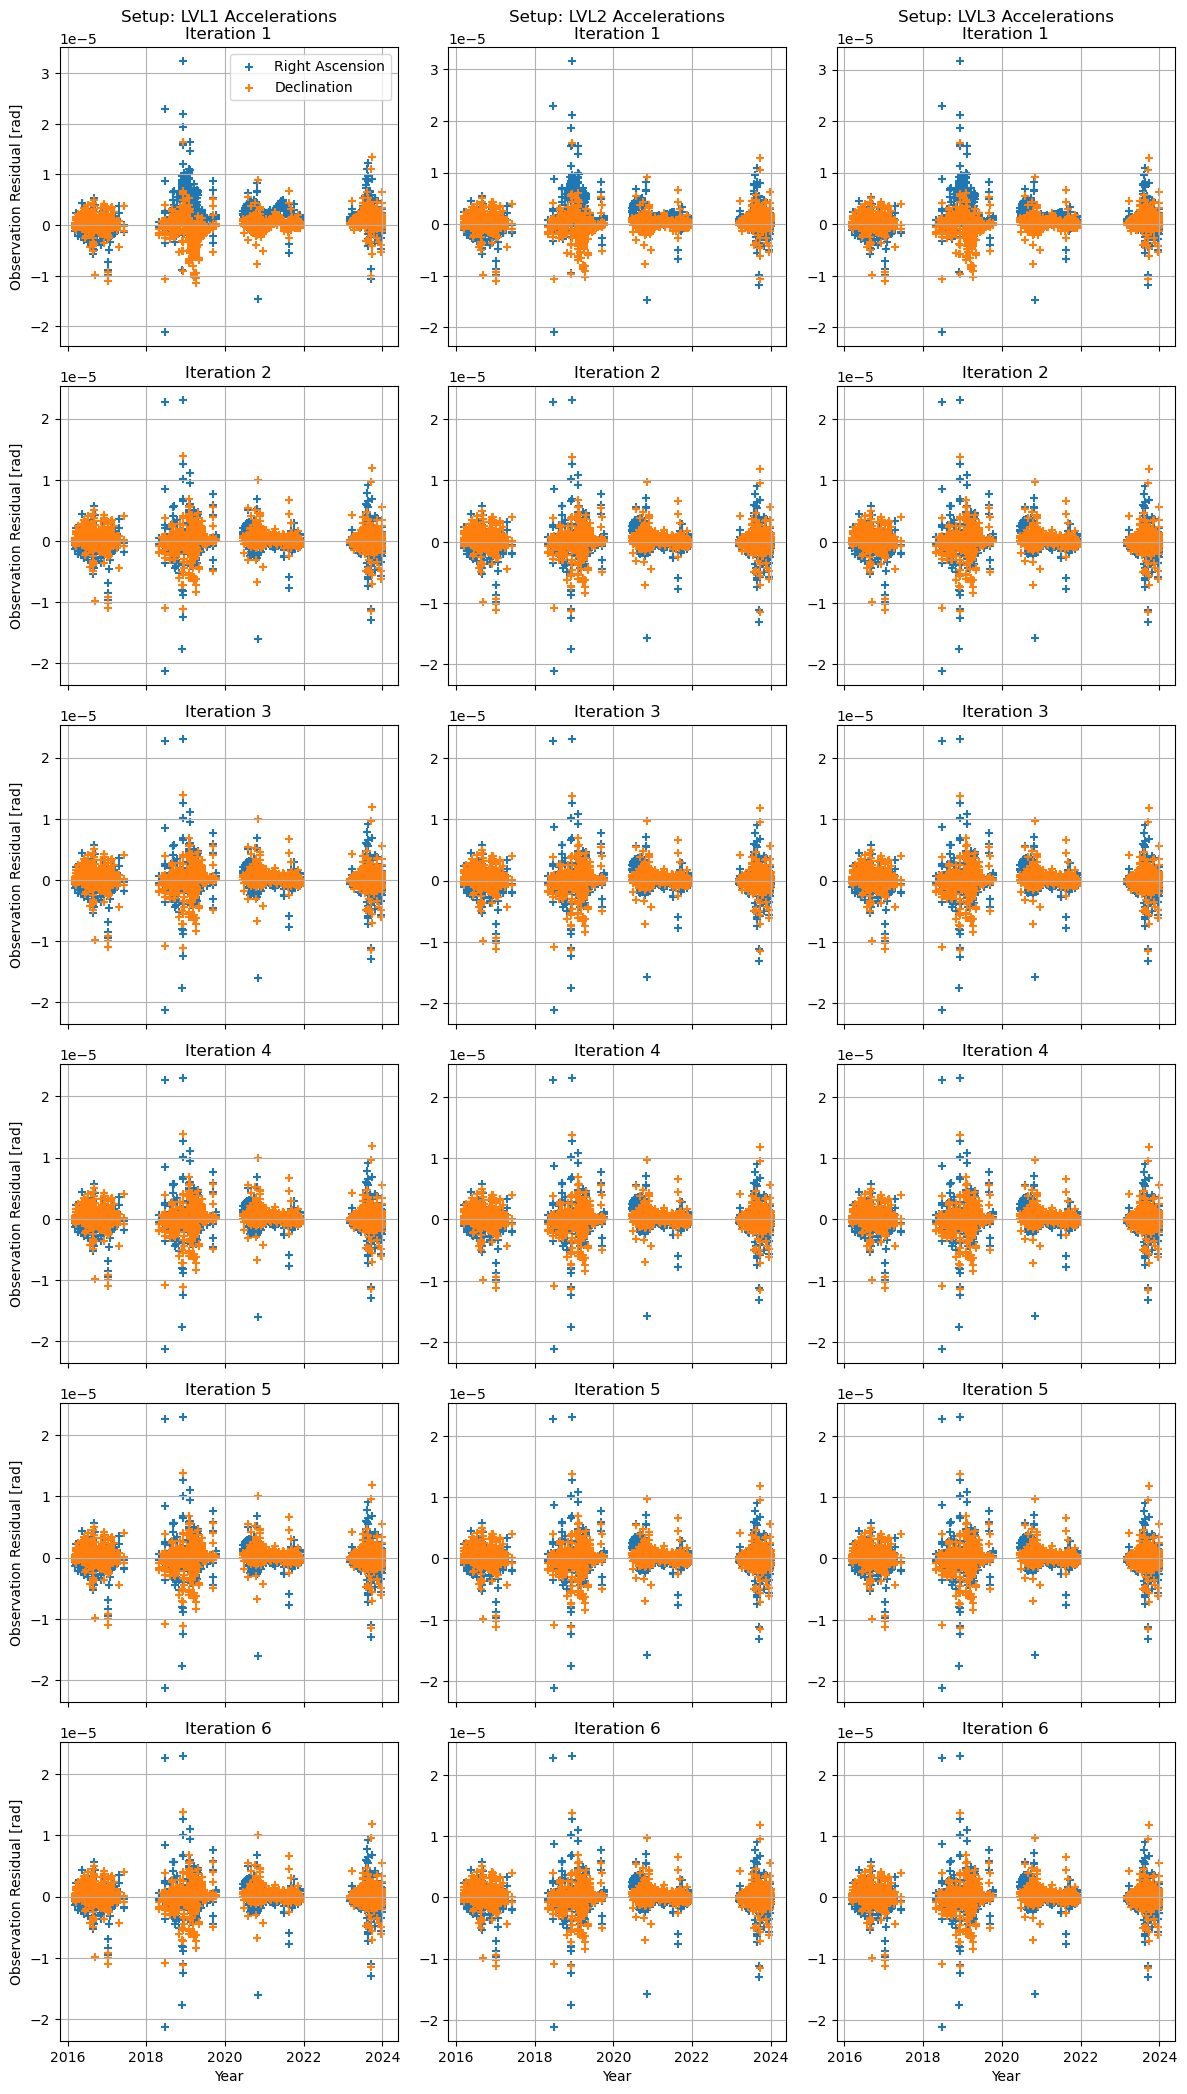

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Year', ylabel='X Cartesian Error [km]'>,
        <Axes: xlabel='Year', ylabel='Y Cartesian Error [km]'>,
        <Axes: xlabel='Year', ylabel='Z Cartesian Error [km]'>],
       dtype=object))

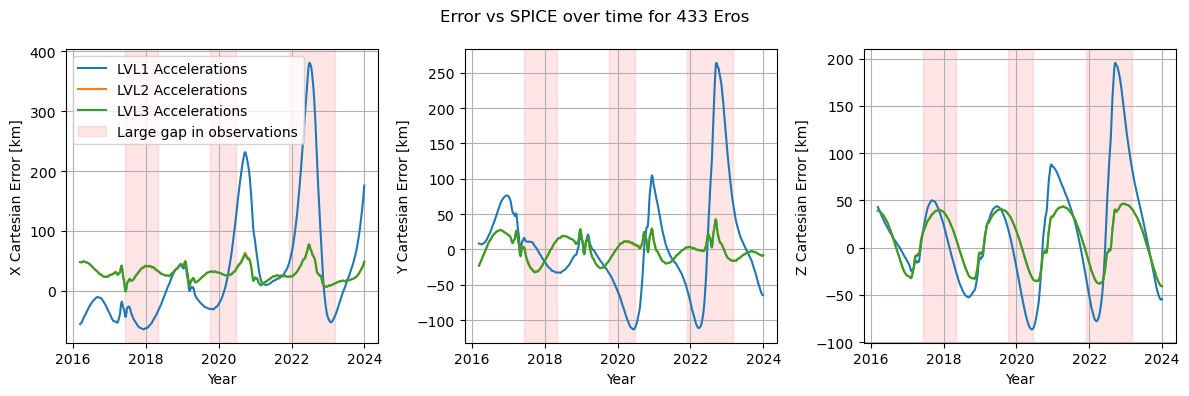

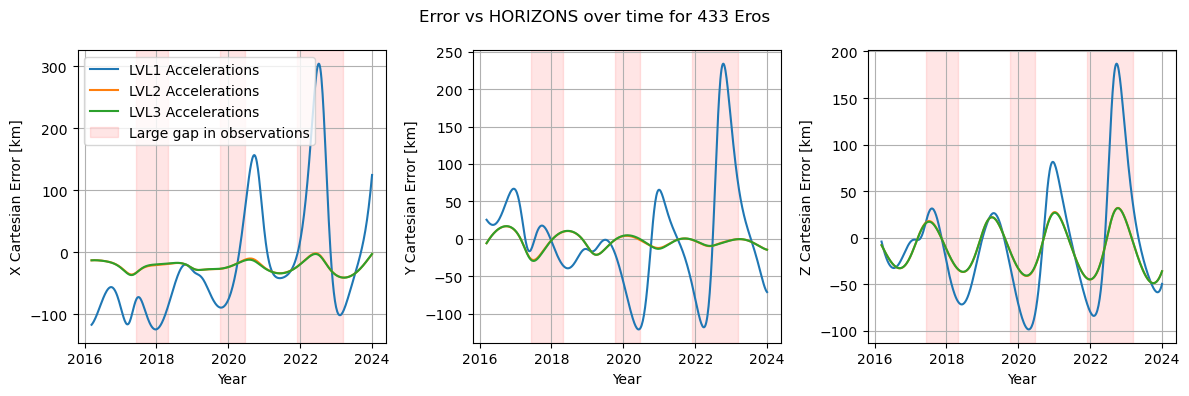

In [67]:
plot_residuals(setup_names, pod_output_set, observation_collection_set)
plot_cartesian(state_estimates_set, setup_names, observation_collection_set, "spice")
plot_cartesian(state_estimates_set, setup_names, observation_collection_set, "horizons")

## Comparison Round 2: Weighting, Star Catalog Corrections and Satellite data

### Weights and Star Catalog Biases
Before running the next round, lets have a quick look at the star catalog corrections and observation weights which are based on the following literature:

- "Star catalog position and proper motion corrections in asteroid astrometry II: The Gaia era" by Eggl et al.
- "Statistical analysis of astrometric errors for the most productive asteroid surveys" by Veres et al.

Star catalogs are large databases of distant celestial objects (mainly stars) featuring details about their position, motion and other properties. Catalogs are used as reference when making observations of objects such as asteroids. Many different catalogs exist each with slightly varying contents and accuracy. The Gaia space telescope, launched in 2013, was designed specifically to measure celestial objects with unprecedented precision. The emergence of the resulting Gaia star catalogs (first appearing in 2016) has made all previous catalogs obsolete, however, observations made with older catalogs still contain their errors. These errors are corrected per observation by enabling the `apply_star_catalog_debias` option in `BatchMPC.to_tudat()`.

Additionally, not all observations have the same quality, to account for this we use weights to increase the effect of quality observations in our estimation. Specific observatories may have a higher accuracy, and individual observatories may improve their observation quality over time. Having too many observations by a single observatory in a short space of time may also introduce a heavy bias in the estimation. The work by Veres et al analyses the most prolific observatories to generate a weighting scheme which is enabled in Tudat using the `apply_star_catalog_debias` option in `BatchMPC.to_tudat()` and subsequently retrieving the weights in the pod_input using `pod_input.set_weights_from_observation_collection().
`

The plots below show star catalog corrections and observation weights for the observation period. Note in the star catalog correction graph how the number of corrections required (non-zero points) quickly reduces after 2016 once operators start implementing GAIA. Note also how a large clump of satellite observations in 2021 gets deweighted to prevent bias towards the satellite.

/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  bias_dataframe = bias_dataframe.stack(level=0)
/var/folders/vw/h3bwl54d4h9fxt45xnkxm86jgk0dgk/T/ipykernel_55800/1262630315.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.95])


(<Figure size 900x400 with 2 Axes>,
 <Axes: ylabel='Weight $[rad^{-1}]$'>,
 <Axes: xlabel='Occurrences'>)

/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


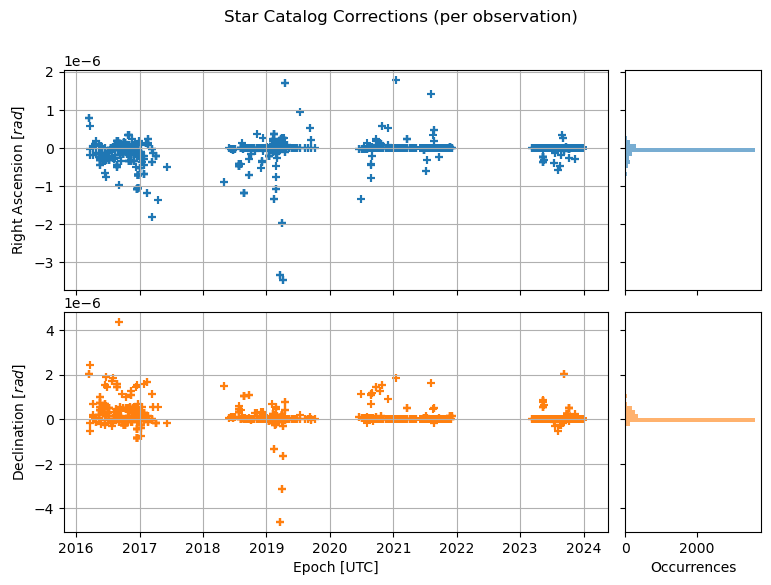

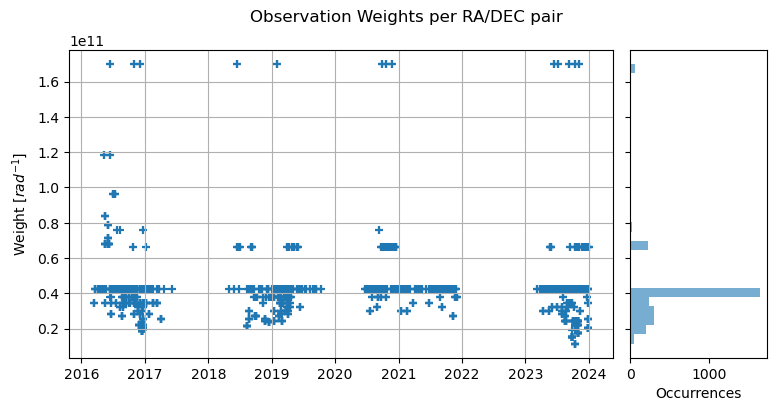

In [68]:
temp = batch.copy()
temp.to_tudat(bodies=bodies, included_satellites=None, apply_weights_VFCC17=True)
# mark weights red if it is a satellite observation

plot_star_catalog_corrections(temp)

plot_observation_weights(temp, include_satellites=False)

### Running the comparison
Lets now run some new setups with those features. As the difference between LVL2 and 3 accelerations is small, we use LVL 2 for all the remaining setups to save on runtime. Using level 2 as a baseline, we then succesively add the star catalog correction, observation weights and finally the satellite observations. The new estimation setups are defined below.


In [69]:
setup_names_2 = [
    "LVL2",
    "LVL2 + star catalog",
    "LVL2 + star catalog + weighting",
    "LVL2 + star catalog + weighting + Sat Data",
]

accel_levels_2 = [2, 2, 2, 2]
use_catalog_cor_2 = [False, True, True, True]
use_weighting_2 = [False, False, True, True]
use_sat_data_2 = [False, False, False, True]

In [70]:
pod_output_set_2 = []
batch_set_2 = []
observation_collection_set_2 = []
estimator_set_2 = []
state_estimates_set_2 = []

# This samples the cartesian state at 500 points over the observation time:
times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

for idx, setup_name in enumerate(setup_names_2):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = perform_estimation(
        bodies,
        acceleration_level=accel_levels_2[idx],
        use_satellite_data=use_sat_data_2[idx],
        apply_star_catalog_debias=use_catalog_cor_2[idx],
        apply_weighting_scheme=use_weighting_2[idx],
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    pod_output_set_2.append(pod_output)
    batch_set_2.append(batch)
    observation_collection_set_2.append(observation_collection)
    estimator_set_2.append(estimator)
    state_estimates_set_2.append(state_estimates)


### Running setup #1 | LVL2 ###

### Running setup #2 | LVL2 + star catalog ###Calculating residuals and partials 6094
Current residual: 2.1537e-06
Parameter update   -36948.1     39270.3    -35710.7 -0.00373075 -0.00196402 -0.00137029
Calculating residuals and partials 6094
Current residual: 1.54699e-06
Parameter update    0.349001    0.0718244    -0.255238  1.89483e-08  1.49977e-08 -1.75532e-08
Calculating residuals and partials 6094
Current residual: 1.54699e-06
Parameter update -0.00628969    0.0127723   0.00479662 -3.52276e-10 -1.42348e-09 -8.50033e-10
Calculating residuals and partials 6094
Current residual: 1.54699e-06
Parameter update -0.00979433    0.0131137   0.00565583 -4.66835e-10 -1.35237e-09 -8.97789e-10
Calculating residuals and partials 6094
Current residual: 1.54699e-06
Parameter update 0.00968609  -0.0200593 -0.00971041 4.16118e-10 2.26915e-09 1.38148e-09
Calculating residuals and partials 6094
Current residual: 1.54699e-06
Maximum number of iterations reached
Parame

/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  bias_dataframe = bias_dataframe.stack(level=0)



### Running setup #3 | LVL2 + star catalog + weighting ###
Calculating residuals and partials 6094
Current residual: 2.13984e-06
Parameter update   -46398.9     36337.8      -23279 -0.00407887  -0.0017823  -0.0027979
Calculating residuals and partials 6094
Current residual: 1.52002e-06
Parameter update    0.337353    0.0887306    -0.234805  1.80318e-08  1.06762e-08 -1.50787e-08
Calculating residuals and partials 6094
Current residual: 1.52002e-06
Parameter update -0.00582786   0.00488734    0.0011636 -2.98573e-10 -4.97484e-10 -2.37088e-10
Calculating residuals and partials 6094
Current residual: 1.52002e-06
Parameter update -0.00602199   0.00888131   0.00339235 -1.78344e-10 -8.79864e-10 -6.06679e-10
Calculating residuals and partials 6094
Current residual: 1.52002e-06
Parameter update  0.0323832  -0.0482704  -0.0193617 1.45626e-09 5.10737e-09 3.16285e-09
Calculating residuals and partials 6094
Current residual: 1.52002e-06
Maximum number of iterations reached
Parameter update  -0.0163

/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  bias_dataframe = bias_dataframe.stack(level=0)



### Running setup #4 | LVL2 + star catalog + weighting + Sat Data ###
Calculating residuals and partials 6094

### Running setup #4 | LVL2 + star catalog + weighting + Sat Data ###
Current residual: 2.13984e-06
Parameter update   -47079.8     36201.6    -20967.5 -0.00408365 -0.00221647 -0.00196589
Calculating residuals and partials 6094
Current residual: 1.521e-06
Parameter update    0.321078     0.083609    -0.199806  1.65276e-08  9.33661e-09 -1.79904e-08
Calculating residuals and partials 6094
Current residual: 1.521e-06
Parameter update  0.0216791  -0.0413797   -0.017218  1.1191e-09 4.53525e-09 2.79465e-09
Calculating residuals and partials 6094
Current residual: 1.521e-06
Parameter update  -0.0150087     0.027963    0.0113575 -7.83103e-10 -3.11847e-09 -1.84478e-09
Calculating residuals and partials 6094
Current residual: 1.521e-06
Parameter update  0.0172474   -0.031987  -0.0140843 7.42699e-10 3.58153e-09 2.13186e-09
Calculating residuals and partials 6094
Current residual: 1.521e

setWeightsFromObservationCollection is deprecated: the weightsMatrixDiagonals_ vector is now by default defined by the weights stored in the ObservationCollection object.
/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  bias_dataframe = bias_dataframe.stack(level=0)


Calculating residuals and partials 6404
Current residual: 7.92237e-06
Parameter update    -182577      159328    -21134.8  -0.0102863  -0.0124983 -0.00666089
Calculating residuals and partials 6404
Current residual: 7.81206e-06
Parameter update   0.724366      -0.293   -0.363077 1.97378e-08 6.18684e-08 5.48418e-09
Calculating residuals and partials 6404
Current residual: 7.81206e-06
Parameter update 0.00600512  -0.0104292 -0.00456211 3.79374e-10 1.14694e-09 6.96537e-10
Calculating residuals and partials 6404
Current residual: 7.81206e-06
Parameter update 0.00859526 -0.00910601 -0.00312548 2.40903e-10 8.31576e-10 5.98019e-10
Calculating residuals and partials 6404
Current residual: 7.81206e-06
Parameter update -0.00459196   0.00360905  0.000301165 -1.87516e-10 -2.08442e-10 -1.77815e-10
Calculating residuals and partials 6404
Current residual: 7.81206e-06
Maximum number of iterations reached
Parameter update-0.000851103   0.00389484   0.00342081  9.62184e-11 -5.57946e-10 -3.41034e-10
Fin

setWeightsFromObservationCollection is deprecated: the weightsMatrixDiagonals_ vector is now by default defined by the weights stored in the ObservationCollection object.


### The results
Before looking at the plots, lets look at the formal errors. We can see that the formal errors are reduced when the weights are applied, indicating that it is working.


In [71]:
for name, p_out in zip(setup_names_2, pod_output_set_2):
    print(name, " | ", list(p_out.formal_errors))

LVL2  |  [7142972752.882148, 5831341999.723811, 3633222742.0647564, 425.87265164902294, 571.7770238205521, 412.8539033780781]
LVL2 + star catalog  |  [7142972697.608933, 5831341958.860123, 3633222771.9904294, 425.87267007414613, 571.7770128623722, 412.85386244132604]
LVL2 + star catalog + weighting  |  [34799.27442849191, 28873.695157550315, 18520.79812824122, 0.0020515770766227114, 0.0028079925279205107, 0.002022392347674382]
LVL2 + star catalog + weighting + Sat Data  |  [34086.84252949516, 28235.192921040987, 18188.390575184454, 0.0020249662438457856, 0.00275247050826865, 0.001982989845905603]


In the residual plot, the first three plots again appear indiscernable. The introduction of satellite data in the fourth image however clearly increases the magnitude of the residuals. This is also reflected in the Cartesian plot, indicating that the addition of satellite data has an adverse affect on the estimation in this scenario. Note that Tudat currently does not feature a outlier removal system, which would reduce the effect of singular outliers which are not captured by the weighting scheme. Additionally, the introduction of satellite data in a different scenario may have beneficial effects.

Since the remaining setups do not show a strong difference, let take a closer look at the setup `LVL2 + star catalog + weighting` for the remainder of the example.

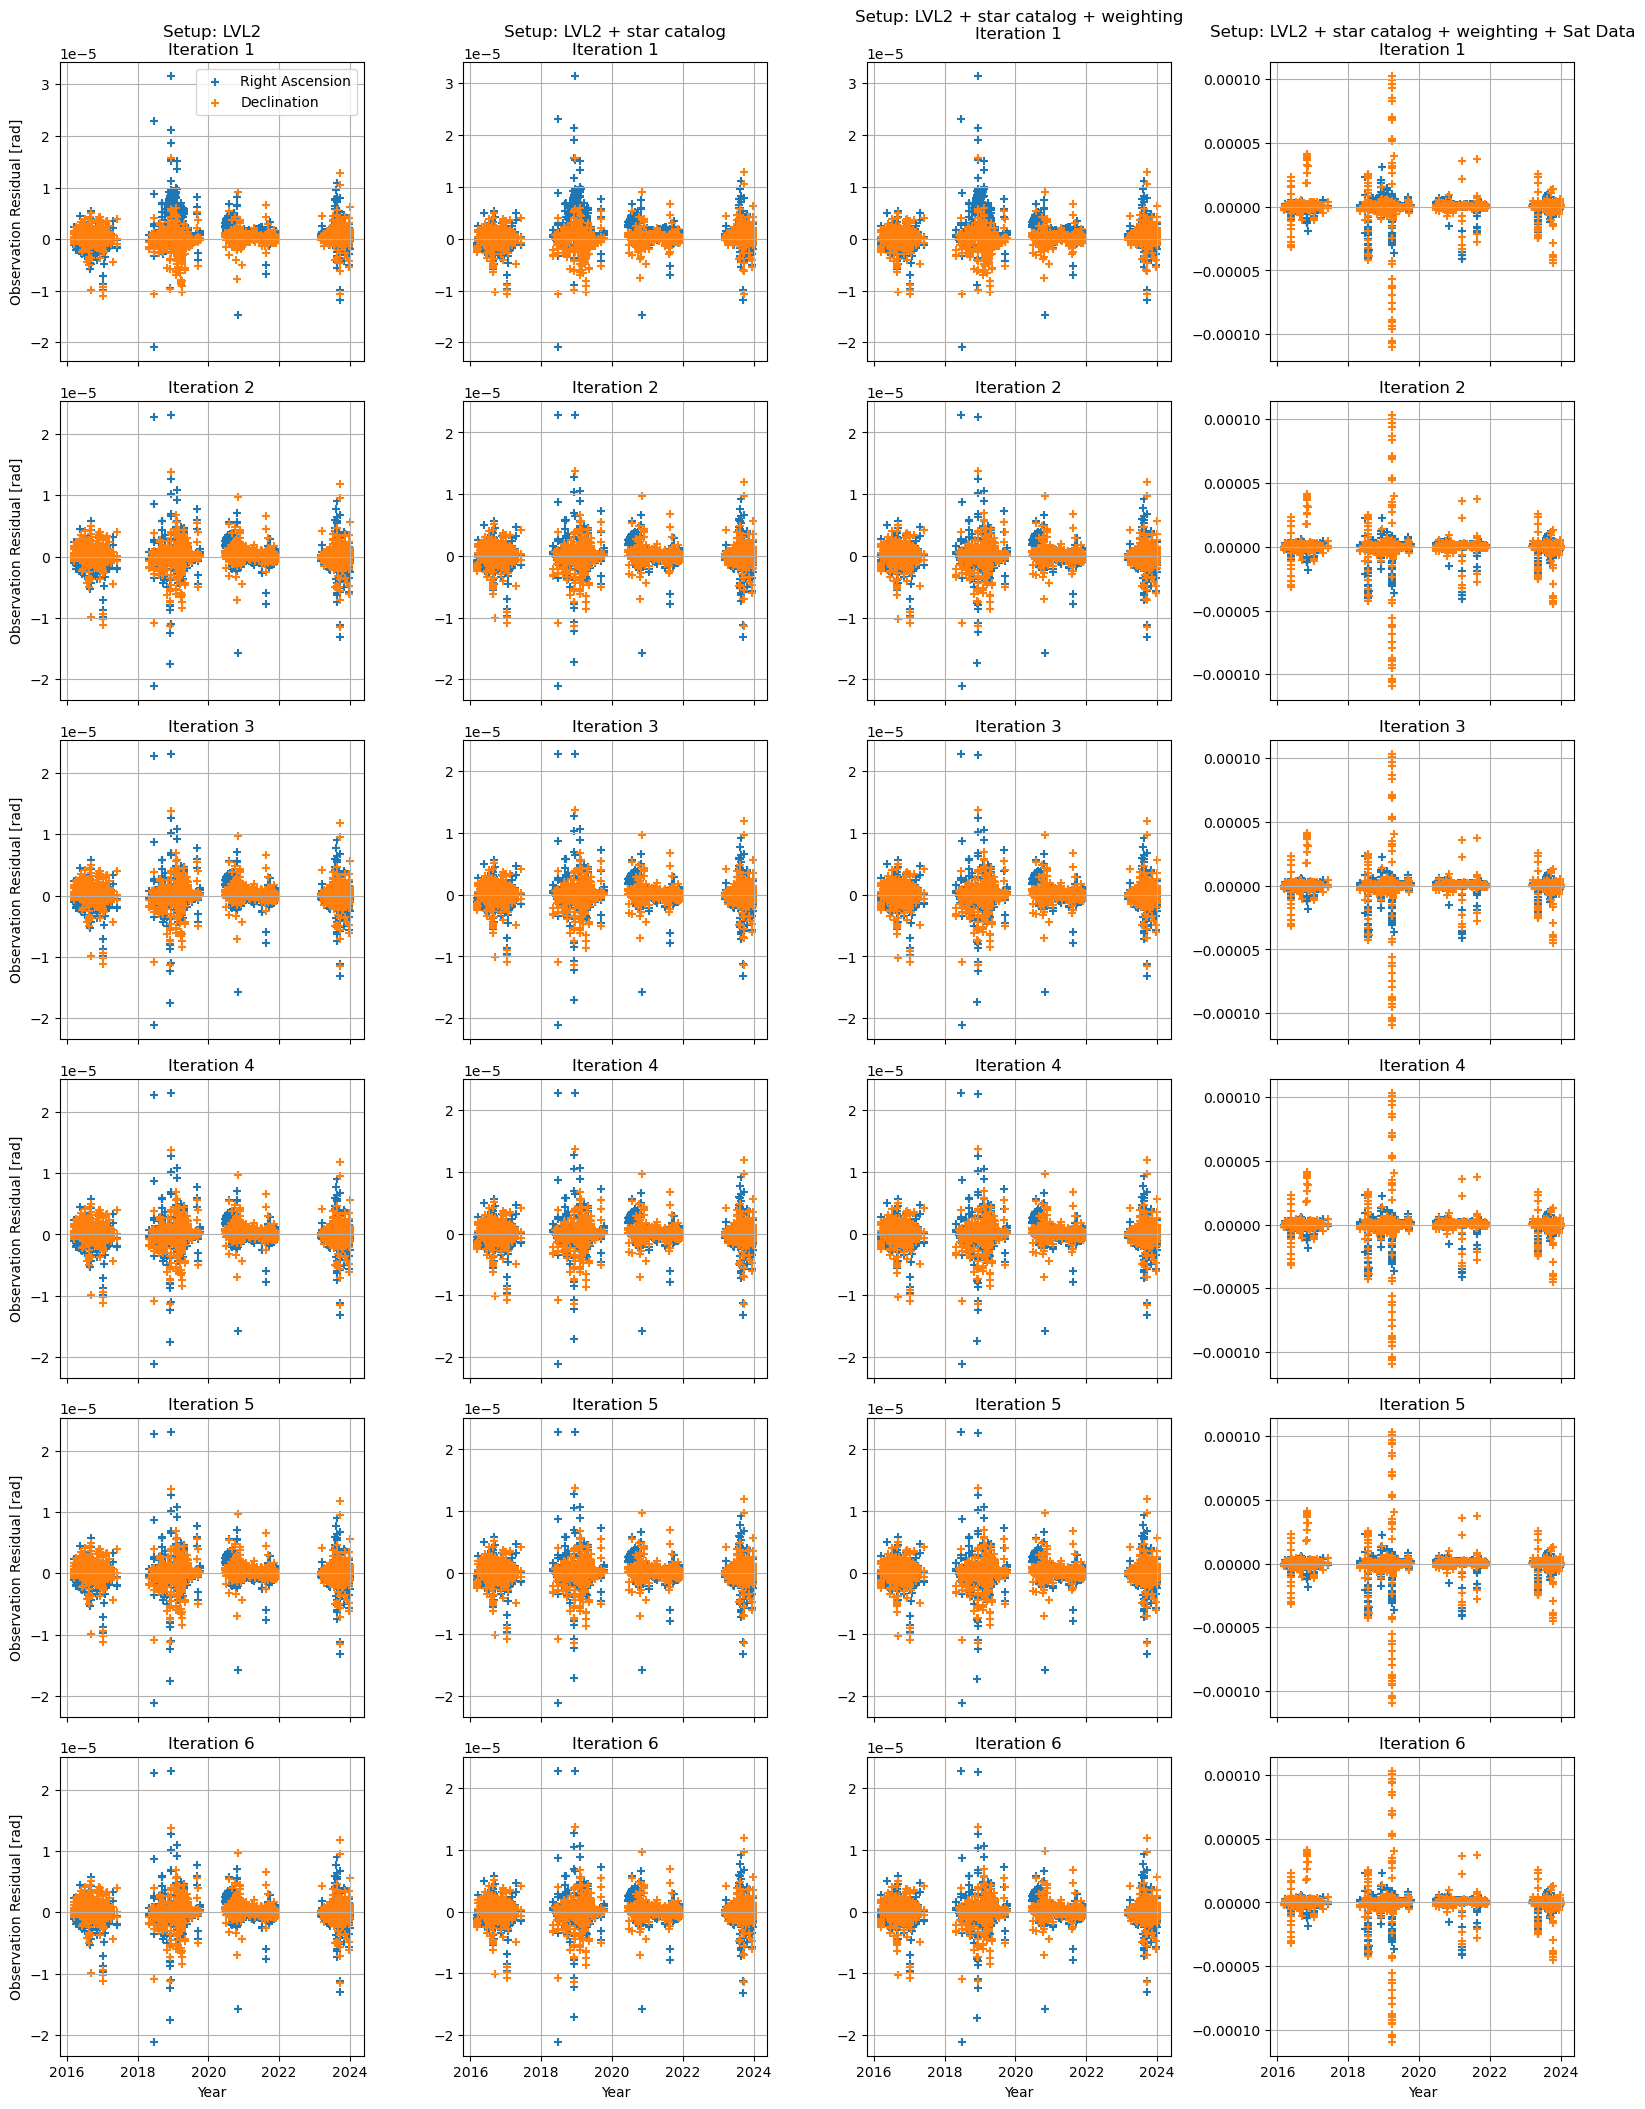

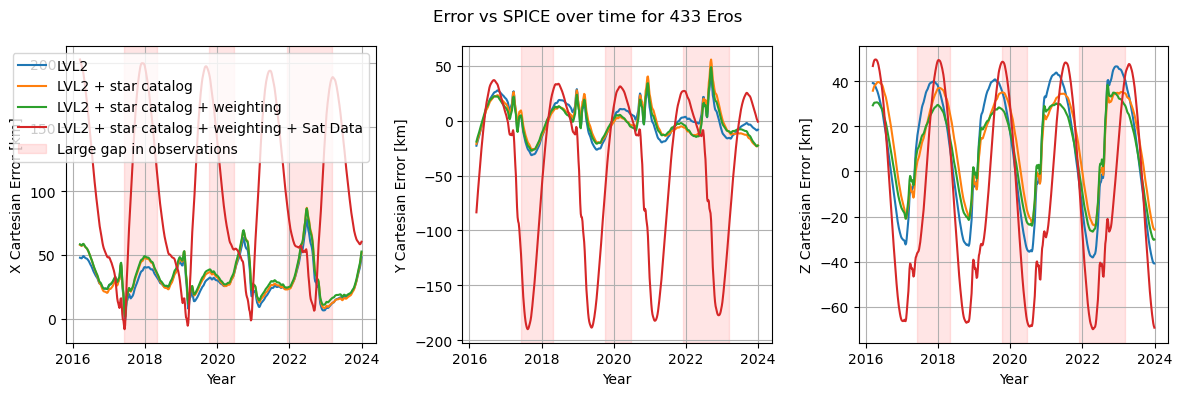

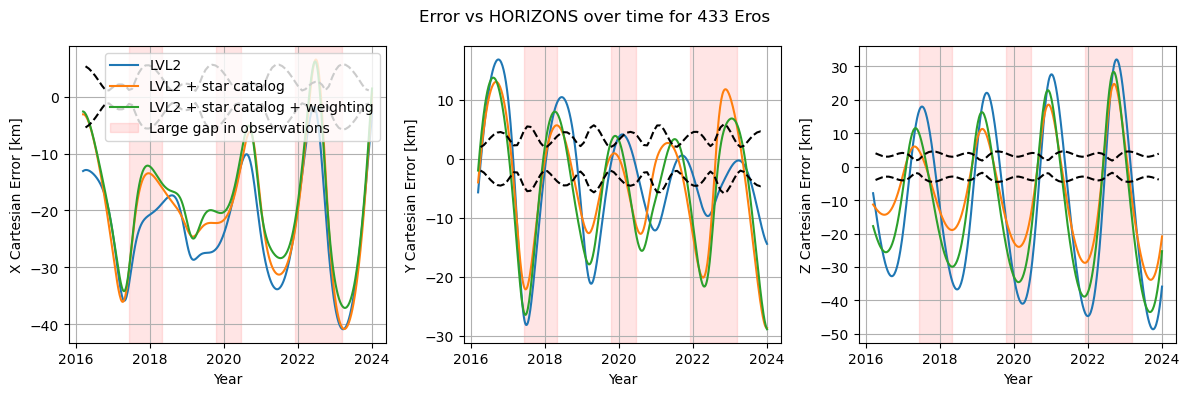

In [72]:
plot_residuals(setup_names_2, pod_output_set_2, observation_collection_set_2)
plot_cartesian(
    state_estimates_set_2, setup_names_2, observation_collection_set_2, "spice"
)
fig, axs = plot_cartesian(
    state_estimates_set_2[:-1],
    setup_names_2[:-1],
    observation_collection_set_2[:-1],
    "horizons",
)

add_uncertainty_table_to_cartesian_plot(axs, ephemeris_uncertainty_table)

## The Final setup
Below we plot a more detailed version of the setup `LVL2 + star catalog + weighting` in both Cartesian and RSW frames and compared to both JPL Horizons and SPICE. From the first plot we can already clearly see that there is a strong difference between the error when compared to SPICE and Horizons. Eventhough we consider both to be "ground-truth" throughout the example, it is important to note that both systems are also estimations. Writers of the `CODES_300ast...` spice kernel, created in 2010, [recommend using Horizons](https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/asteroids/AAREADME_Asteroids_SPKs.txt) for a more up to date ephemeris of asteroids.

The accuracy of Horizons' ephemeris of 433 eros is given in the [SBDB](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=433) gives a 1-sigma uncertainty of about 1.6e-10 AU = 24 meters for the semi major axis and about 1.2e-6 degrees in inclination (about 4.5 km at maximum). Looking at the error in the RSW frame shows that we are off in the order of 10s of kilometers. Indeed looking at the RSW error for Horizons we can clearly see a periodicity in the error. This indicates that there is potentially an acceleration that is modelled differently between our estimation and that of Horizons. We can also see hat the error is highest in the cross track direction. While the introduction of additional bodies in our acceleration models yielded no effects, it may be that Horizons models some of the mayor bodies (such as Jupiter) differently.

Running the setup for a longer period of time and analysing the frequency domain may yield answers as to where the discrepancy lies.

In [73]:
chosen_setup_index = 2
# chosen_setup_index = 3 # consider trying index 3 to analyse at the satellite setup more closely.

final_state_estimate = state_estimates_set_2[chosen_setup_index]
final_setup_name = setup_names_2[chosen_setup_index]
final_observation_collection = observation_collection_set_2[chosen_setup_index]
final_estimator = estimator_set_2[chosen_setup_index]
final_pod_output = pod_output_set_2[chosen_setup_index]

print(f"Final setup: {final_setup_name}")

Final setup: LVL2 + star catalog + weighting


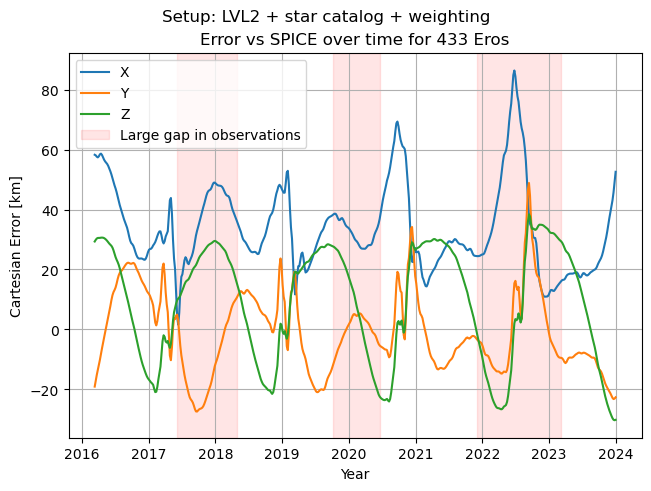

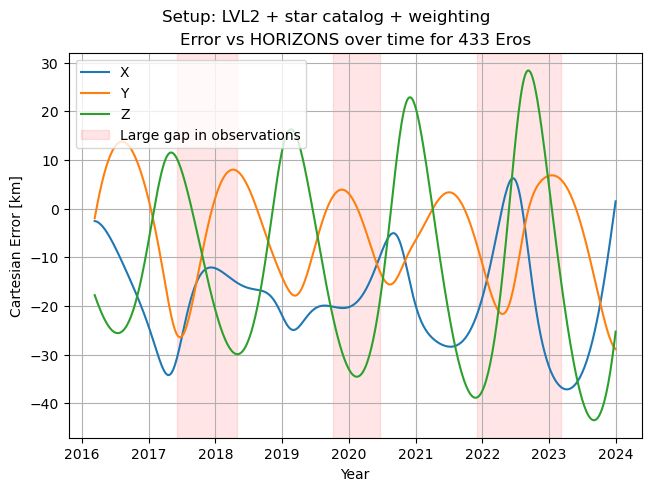

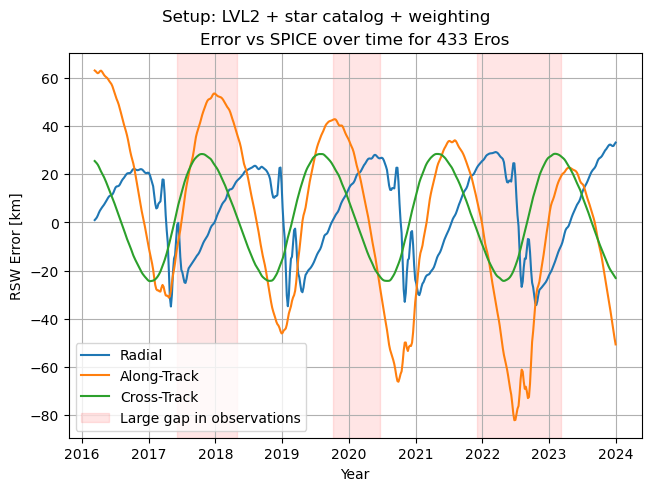

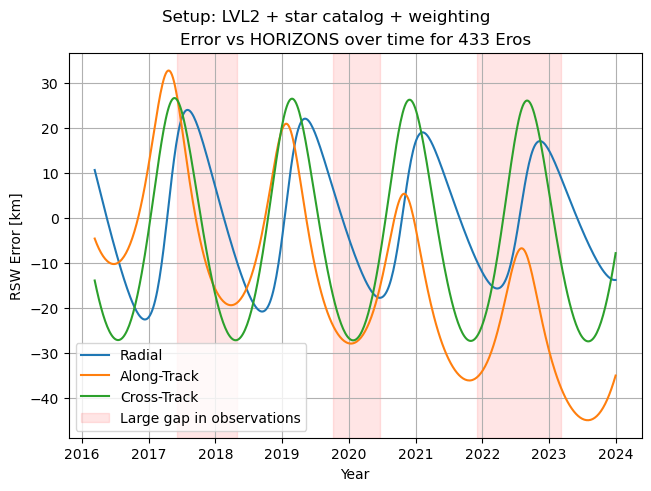

In [74]:
plot_cartesian_single(
    final_state_estimate,
    final_setup_name,
    final_observation_collection,
    "spice",
    in_RSW=False,
)
fig_jpl_xyz, ax_jpl_xyz = plot_cartesian_single(
    final_state_estimate,
    final_setup_name,
    final_observation_collection,
    "horizons",
    in_RSW=False,
)
plot_cartesian_single(
    final_state_estimate,
    final_setup_name,
    final_observation_collection,
    "spice",
    in_RSW=True,
)
fig, ax = plot_cartesian_single(
    final_state_estimate,
    final_setup_name,
    final_observation_collection,
    "horizons",
    in_RSW=True,
)

We can also add the formal errors of our solution to the previous plots.
In order to do that, we propagate our covariance to the output epochs, transform it to the Eros-RSW frame and then compute the corresponding formal errors from the covariance.

In [75]:
from tudatpy.numerical_simulation import estimation

_, covariance_history = estimation.propagate_covariance_split_output(
    final_pod_output.covariance,
    final_estimator.state_transition_interface,
    times_get_eph,
)


inertial_to_rsw_state_rotation_matrices = []
for state in final_state_estimate:

    inertial_to_rsw_rm = np.zeros((6, 6))
    i2rsw = inertial_to_rsw_rotation_matrix(state)
    inertial_to_rsw_rm[:3, :3] = i2rsw
    inertial_to_rsw_rm[3:, 3:] = i2rsw

    inertial_to_rsw_state_rotation_matrices.append(inertial_to_rsw_rm)


covariance_history_rsw = [
    inertial_to_rsw_state_rotation_matrices[i]
    @ covariance_history[i]
    @ inertial_to_rsw_state_rotation_matrices[i].T
    for i in range(len(covariance_history))
]
formal_error_history_rsw = np.array(
    [np.sqrt(np.diag(cov)) for cov in covariance_history_rsw]
)

/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/numerical_simulation/__init__.py:2: FutureWarning: tudatpy.numerical_simulation is deprecated. Use tudatpy.dynamics and/or tudatpy.estimation.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/tudatpy/numerical_simulation/estimation/__init__.py:2: FutureWarning: tudatpy.numerical_simulation.estimation is deprecated. Use tudatpy.estimation.observations, tudatpy.estimation.observations_setup and/or tudatpy.estimation.estimation_analysis instead.
  warnings.warn(


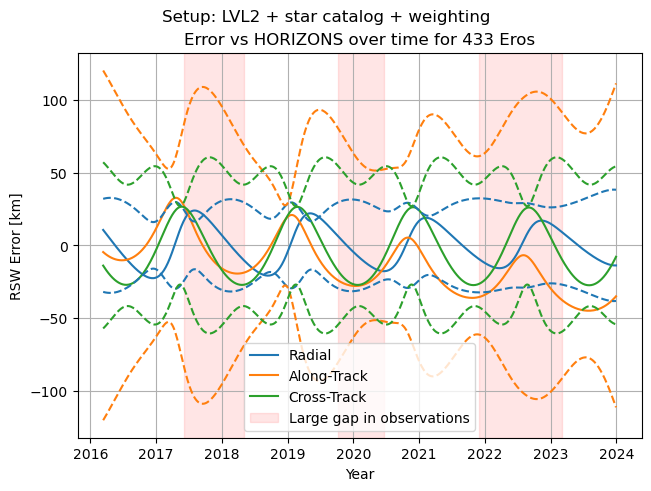

In [76]:
add_formal_error_to_cartesian_single_plot(
    ax, times_get_eph, formal_error_history_rsw, in_RSW=True
)
fig

This concludes the main part of this example. Consider experimenting with the setup: using different space telescopes, trying out longer runtimes, different target bodies and different acceleration models.

## Additional plots
Below are the same comparison plots used in the original example. Consider comparing the results to the previous example. Also consider running the changing the plots to the final setup with satellites to compare the residuals.

### Residuals Correlation Matrix

Calculating residuals and partials 6094


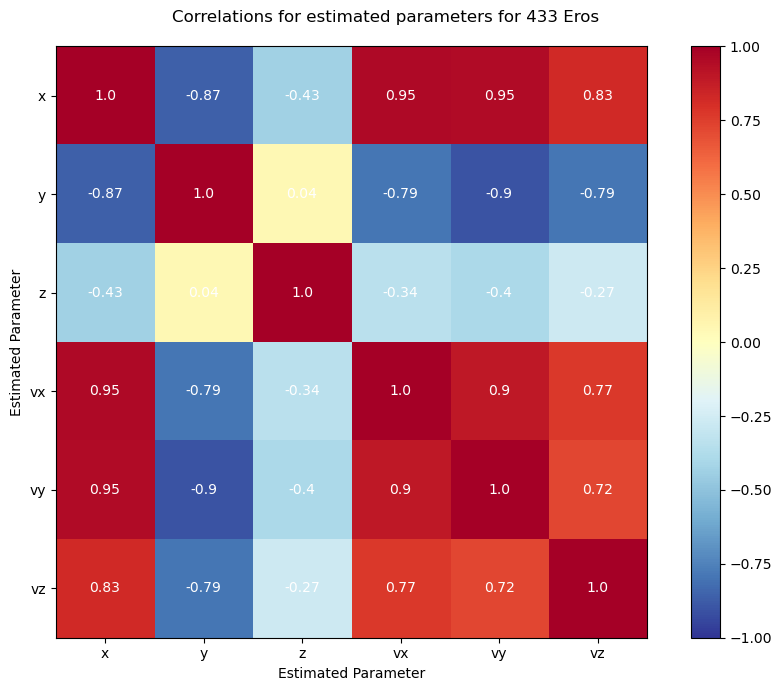

In [85]:
# Corellation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation.estimation_analysis.CovarianceAnalysisInput(
    final_observation_collection
)
covariance_output = final_estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations

estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 2), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {target_name}")

fig.set_tight_layout(True)

### Pre-Fit and Post-Fit residuals highlighted per observatory

In [86]:
num_observatories = 10
consider_satellites = use_sat_data_2[chosen_setup_index]

residual_history = final_pod_output.residual_history
residual_times = (
    np.array(final_observation_collection.concatenated_times) / (86400 * 365.25) + 2000
)
prefitresiduals = np.array(residual_history[:, 0])
finalresiduals = np.array(residual_history[:, -1])

In [87]:
# This piece of code collects the 10 largest observatories
observatory_names = (
    batch.observatories_table(exclude_space_telescopes=True)
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
    .set_index("Code")
)
top_observatories = observatory_names.index.tolist()
# This piece of code creates a `concatenated_receiving_observatories` map
# to identify the observatories by their MPC code instead of an internally used id
residuals_observatories = final_observation_collection.concatenated_link_definition_ids
unique_observatories = set(residuals_observatories)

observatory_link_to_mpccode = {
    idx: final_observation_collection.link_definition_ids[idx][
        observable_models_setup.links.receiver
    ].reference_point
    for idx in unique_observatories
}

# the resulting map (MPC code for each item in the residuals_history):
concatenated_receiving_observatories = np.array(
    [observatory_link_to_mpccode[idx] for idx in residuals_observatories]
)

# mask for the observatories not in top 10:
mask_not_top = [
    (False if observatory in top_observatories else True)
    for observatory in concatenated_receiving_observatories
]

# get the number of observations by the other observatories
# (divide by two because the observations are concatenated RA,DEC in this list)
n_obs_not_top = int(sum(mask_not_top) / 2)

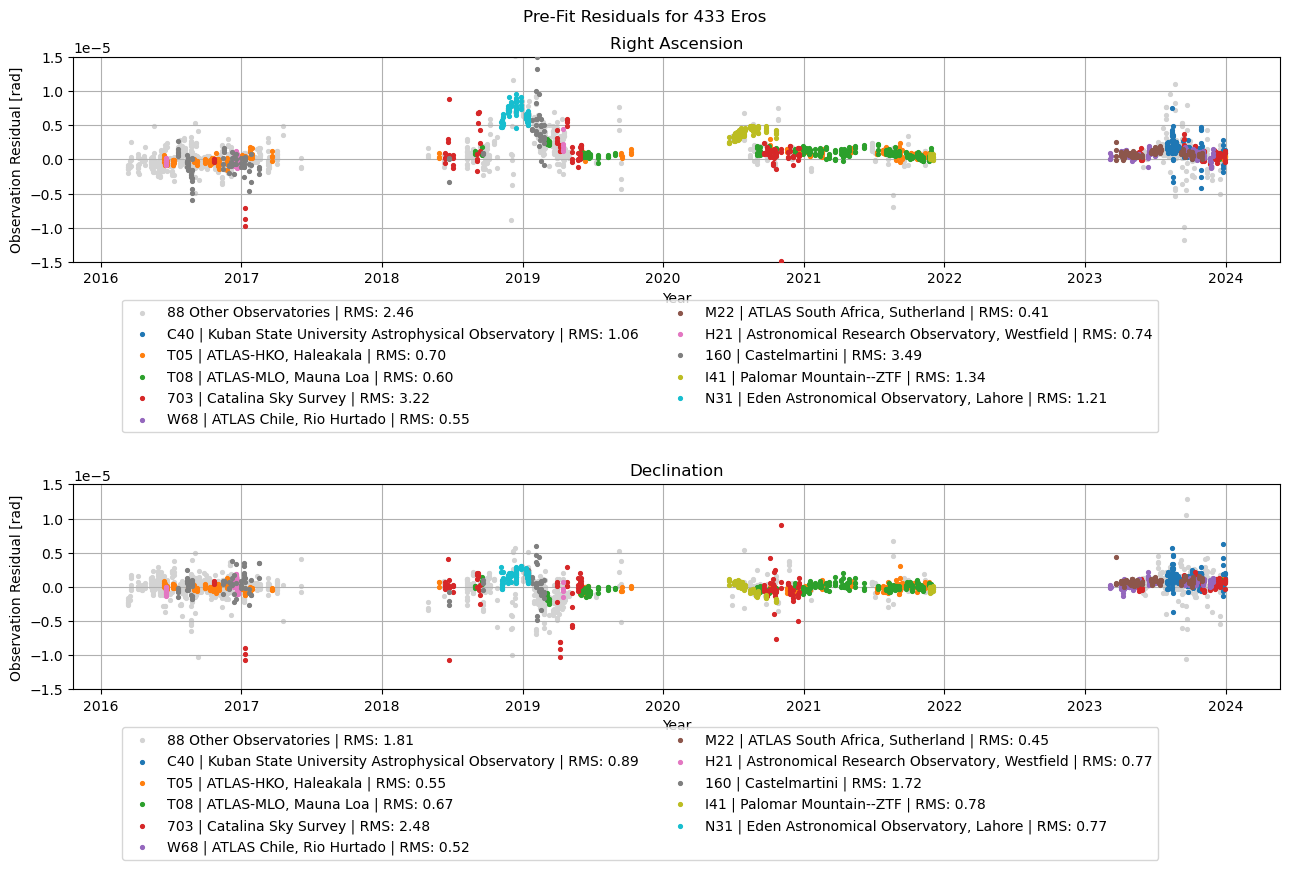

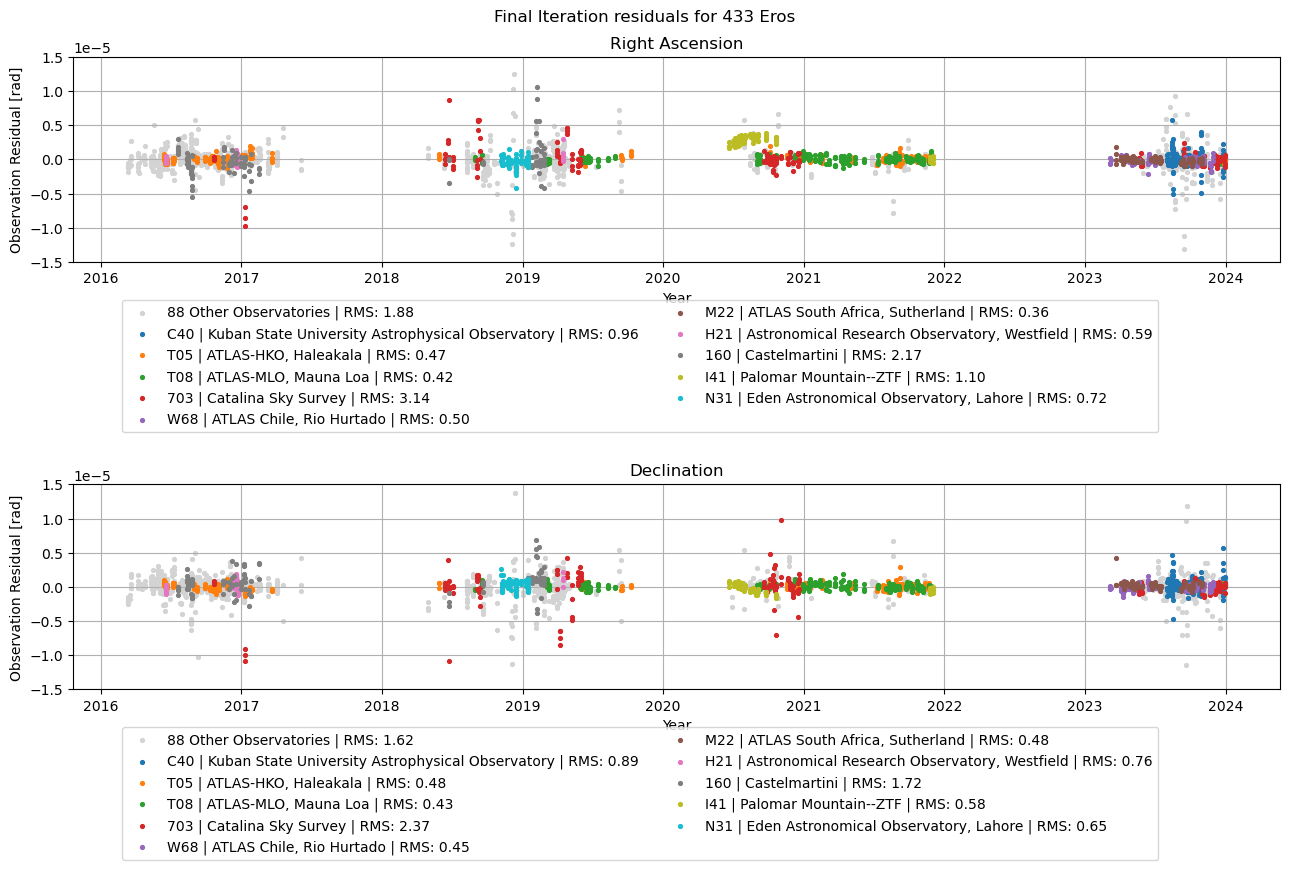

In [88]:
######## PREFIT RESIDUALS PLOTTING ################
fig, axs = plt.subplots(2, 1, figsize=(13, 9))

# Plot remaining observatories first
# RA

axs[0].scatter(
    residual_times[mask_not_top][::2],
    prefitresiduals[mask_not_top][::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | RMS: {np.std(prefitresiduals[mask_not_top][::2]) * 1e6:.2f}",
    color="lightgrey",
)
# DEC
axs[1].scatter(
    residual_times[mask_not_top][1::2],
    prefitresiduals[mask_not_top][1::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | RMS: {np.std(prefitresiduals[mask_not_top][1::2]) * 1e6:.2f}",
    color="lightgrey",
)

# plots the highlighted top 10 observatories
for observatory in top_observatories:
    name_ra = f"{observatory} | {observatory_names.loc[observatory].Name} | RMS: {np.std(prefitresiduals[concatenated_receiving_observatories == observatory][::2]) * 1e6:.2f}"
    name_dec = f"{observatory} | {observatory_names.loc[observatory].Name} | RMS: {np.std(prefitresiduals[concatenated_receiving_observatories == observatory][1::2]) * 1e6:.2f}"

    axs[0].scatter(
        residual_times[concatenated_receiving_observatories == observatory][::2],
        prefitresiduals[concatenated_receiving_observatories == observatory][::2],
        marker=".",
        s=30,
        label=name_ra,
        zorder=100,
    )
    axs[1].scatter(
        residual_times[concatenated_receiving_observatories == observatory][1::2],
        prefitresiduals[concatenated_receiving_observatories == observatory][1::2],
        marker=".",
        s=30,
        label=name_dec,
        zorder=100,
    )

axs[0].legend(ncols=2, loc="upper center", bbox_to_anchor=(0.47, -0.15))
axs[1].legend(ncols=2, loc="upper center", bbox_to_anchor=(0.47, -0.15))

for ax in fig.get_axes():
    ax.grid()
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_xlabel("Year")
    # this step hides a few outliers (~3 observations)
    ax.set_ylim(-1.5e-5, 1.5e-5)

axs[0].set_title("Right Ascension")
axs[1].set_title("Declination")

fig.suptitle(f"Pre-Fit Residuals for {target_name}")
fig.set_tight_layout(True)

plt.show()

######## POSTFIT RESIDUALS PLOTTING ################
fig, axs = plt.subplots(2, 1, figsize=(13, 9))

# Plot remaining observatories first
# RA
axs[0].scatter(
    residual_times[mask_not_top][::2],
    finalresiduals[mask_not_top][::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | RMS: {np.std(finalresiduals[mask_not_top][::2]) * 1e6:.2f}",
    color="lightgrey",
)
# DEC
axs[1].scatter(
    residual_times[mask_not_top][1::2],
    finalresiduals[mask_not_top][1::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | RMS: {np.std(finalresiduals[mask_not_top][1::2]) * 1e6:.2f}",
    color="lightgrey",
)

# plots the highlighted top 10 observatories
for observatory in top_observatories:
    name_ra = f"{observatory} | {observatory_names.loc[observatory].Name} | RMS: {np.std(finalresiduals[concatenated_receiving_observatories == observatory][::2]) * 1e6:.2f}"
    name_dec = f"{observatory} | {observatory_names.loc[observatory].Name} | RMS: {np.std(finalresiduals[concatenated_receiving_observatories == observatory][1::2]) * 1e6:.2f}"
    axs[0].scatter(
        residual_times[concatenated_receiving_observatories == observatory][::2],
        finalresiduals[concatenated_receiving_observatories == observatory][::2],
        marker=".",
        s=30,
        label=name_ra,
        zorder=100,
    )
    axs[1].scatter(
        residual_times[concatenated_receiving_observatories == observatory][1::2],
        finalresiduals[concatenated_receiving_observatories == observatory][1::2],
        marker=".",
        s=30,
        label=name_dec,
        zorder=100,
    )

axs[0].legend(ncols=2, loc="upper center", bbox_to_anchor=(0.47, -0.15))
axs[1].legend(ncols=2, loc="upper center", bbox_to_anchor=(0.47, -0.15))

for ax in fig.get_axes():
    ax.grid()
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_xlabel("Year")
    # this step hides a few outliers (~3 observations)
    ax.set_ylim(-1.5e-5, 1.5e-5)

axs[0].set_title("Right Ascension")
axs[1].set_title("Declination")

fig.suptitle(f"Final Iteration residuals for {target_name}")
fig.set_tight_layout(True)

plt.show()



### Histograms per observatory

In [89]:
num_observatories = 6
nbins = 20
number_of_columns = 2
transparency = 0.6

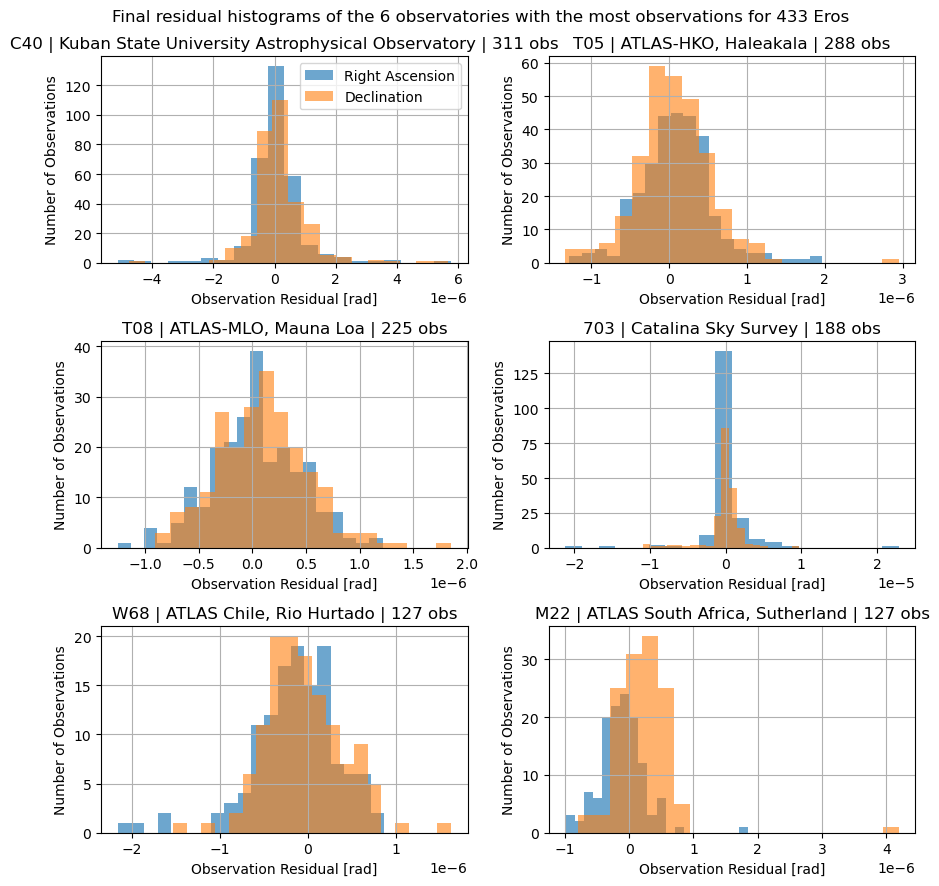

In [90]:
number_of_rows = (
    int(num_observatories / number_of_columns)
    if num_observatories % number_of_columns == 0
    else int((num_observatories + 1) / number_of_columns)
)

# we retrieve the observatory names again
observatory_names_hist = (
    batch.observatories_table(exclude_space_telescopes=True)
    .set_index("Code")
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
)

top_observatories_hist = observatory_names_hist.index.tolist()


fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(4.5 * number_of_columns, 3 * number_of_rows),
)

axs = axs.flatten()

for idx, observatory in enumerate(top_observatories_hist):
    name = f"{observatory} | {observatory_names_hist.loc[observatory].Name} | {int(observatory_names_hist.loc[observatory]['count'])} obs"

    axs[idx].hist(
        finalresiduals[concatenated_receiving_observatories == observatory][0::2],
        bins=nbins,
        alpha=transparency + 0.05,
        label="Right Ascension",
    )
    axs[idx].hist(
        finalresiduals[concatenated_receiving_observatories == observatory][1::2],
        bins=nbins,
        alpha=transparency,
        label="Declination",
    )

    axs[idx].grid()
    axs[idx].set_title(name)
    axs[idx].set_ylabel("Number of Observations")
    axs[idx].set_xlabel("Observation Residual [rad]")

axs[0].legend()

fig.suptitle(
    f"Final residual histograms of the {num_observatories} observatories with the most observations for {target_name}"
)
fig.set_tight_layout(True)
plt.show()

# Plots for IAC paper

The following plots were created for the paper title "Open-Source High-Fidelity Orbit Estimation for Planetary Science and Space Situational Awareness Using the Tudat Software", presented at IAC 2025.

Since these plots are specifically tailored to the paper format, they contain a number of hard-corded setups and are thus not integrated in the previous plotting functions.

/var/folders/vw/h3bwl54d4h9fxt45xnkxm86jgk0dgk/T/ipykernel_55800/1262630315.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/opt/homebrew/anaconda3/envs/tudatpy_fotos/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


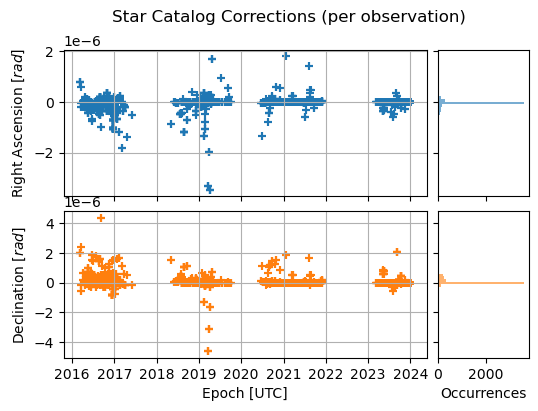

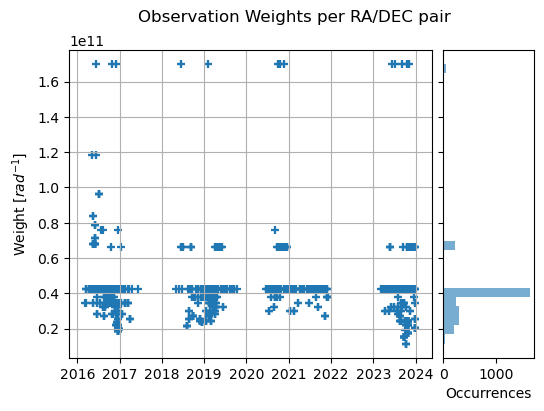

In [91]:
fig, _, _, _, _ = plot_star_catalog_corrections(temp, figsize=(6, 4))

# fig.savefig("Eros_observation_weights_per_RA_DEC_pair.pdf")

fig, _, _ = plot_observation_weights(temp, include_satellites=False, figsize=(6, 4))
# fig.savefig("Eros_star_catalog_corrections.pdf")

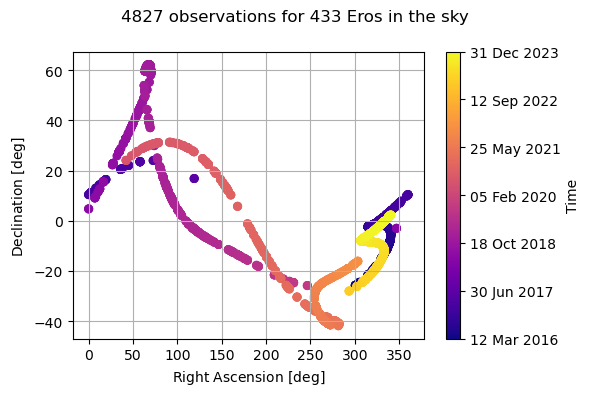

In [92]:
fig = batch.plot_observations_sky(figsize=(6, 4))
fig.suptitle(f"{batch.size} observations for {target_name} in the sky")
fig.axes[0].get_legend().remove()

# fig.savefig("Eros_observations_sky.pdf")

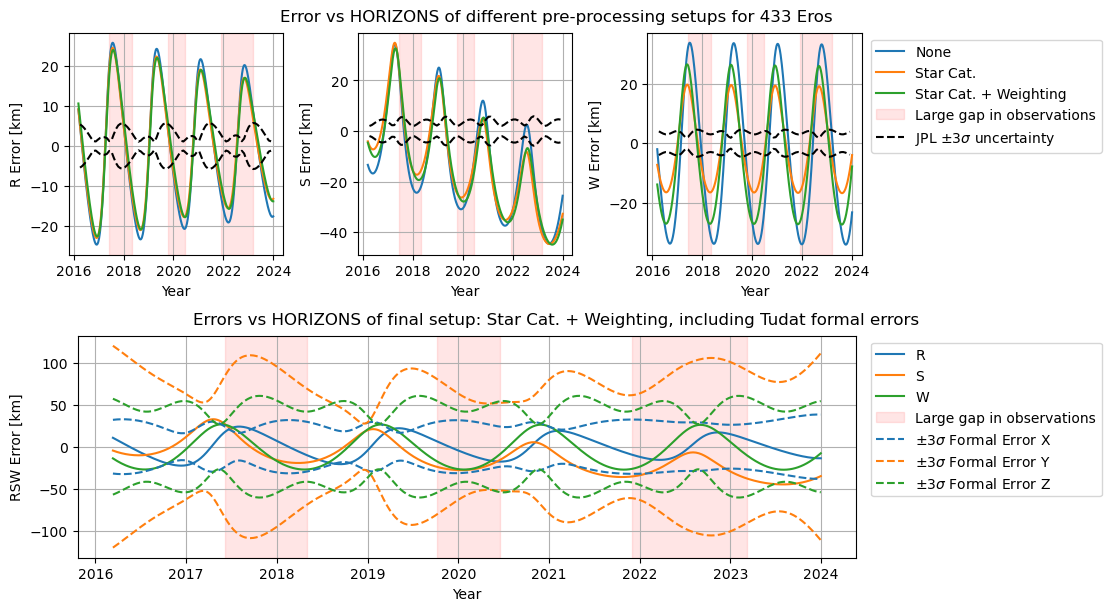

In [93]:
comparison_reference = "horizons"

fig = plt.figure(layout="constrained", figsize=(11, 6))

####################################################
# TOP FIGURES
####################################################

subfigs = fig.subfigures(2, 1)
axs = subfigs[0].subplots(1, 3)

comparison_reference = check_comparison_reference(comparison_reference)

gap_ranges = get_gap_ranges(observation_collection_set[0])

# retrieve the states for a list of times in:
# SPICE
if comparison_reference == "spice":

    reference_states = np.array(
        [
            spice.get_body_cartesian_state_at_epoch(
                target_spkid,
                central_bodies[0],
                global_frame_orientation,
                "NONE",
                timee,
            )
            for timee in times_get_eph
        ]
    )

# Horizons
elif comparison_reference == "horizons":

    horizons_query = HorizonsQuery(
        query_id=f"{target_mpc_code};",
        location=f"500@{global_frame_origin}",
        epoch_list=list(times_get_eph),
        extended_query=True,
    )
    reference_states = horizons_query.cartesian(
        frame_orientation=global_frame_orientation
    )[:, 1:]

times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate for plot ticks


state_estimates_set = state_estimates_set_2[:-1]
setup_names = ["None", "Star Cat.", "Star Cat. + Weighting"]

for state_est, setup_name in zip(state_estimates_set, setup_names):
    # Error in kilometers
    error_to_reference = (reference_states - np.array(state_est)) / 1000

    error_to_reference = np.array(
        [
            inertial_to_rsw_rotation_matrix(reference_state) @ error[:3]
            for reference_state, error in zip(reference_states, error_to_reference)
        ]
    )

    axs[0].plot(times_plot, error_to_reference[:, 0], label=setup_name)
    axs[1].plot(times_plot, error_to_reference[:, 1], label=setup_name)
    axs[2].plot(times_plot, error_to_reference[:, 2], label=setup_name)

for idx, ax in enumerate(axs.flatten()):
    # show areas where there are no observations:
    for i, gap in enumerate(gap_ranges):
        ax.axvspan(
            xmin=gap[0],
            xmax=gap[1],
            color="red",
            alpha=0.1,
            label="Large gap in observations" if i == 0 else None,
        )
    ax.grid()

# axs[0].legend(ncol=1, loc="lower right")
axs[0].set_ylabel("R Error [km]")
axs[1].set_ylabel("S Error [km]")
axs[2].set_ylabel("W Error [km]")
axs[0].set_xlabel("Year")
axs[1].set_xlabel("Year")
axs[2].set_xlabel("Year")

subfigs[0].suptitle(
    f"Error vs {comparison_reference.upper()} of different pre-processing setups for {target_name}"
)
add_uncertainty_table_to_cartesian_plot(axs, ephemeris_uncertainty_table)

h, l = axs[2].get_legend_handles_labels()
axs[2].legend(
    handles=h[:-1], labels=l[:-1], ncol=1, loc="upper left", bbox_to_anchor=(1.01, 1.0)
)


####################################################
# BOTTOM FIGURE
####################################################

ax = subfigs[1].subplots()
subfigs[1].suptitle(
    f"Errors vs {comparison_reference.upper()} of final setup: {setup_names[chosen_setup_index]}, including Tudat formal errors"
)

state_estimate = state_estimates_set_2[chosen_setup_index]

error_to_reference = (reference_states - np.array(state_estimate)) / 1000

error_to_reference = np.array(
    [
        inertial_to_rsw_rotation_matrix(reference_state) @ error[:3]
        for reference_state, error in zip(reference_states, error_to_reference)
    ]
)

# plot
ax.plot(times_plot, error_to_reference[:, 0], label="R")
ax.plot(times_plot, error_to_reference[:, 1], label="S")
ax.plot(times_plot, error_to_reference[:, 2], label="W")


for i, gap in enumerate(gap_ranges):
    ax.axvspan(
        xmin=gap[0],
        xmax=gap[1],
        color="red",
        alpha=0.1,
        label="Large gap in observations" if i == 0 else None,
    )
ax.grid()

frame_name = "RSW"

ax.set_xlabel("Year")
ax.set_ylabel(f"{frame_name} Error [km]")

add_formal_error_to_cartesian_single_plot(
    ax, times_get_eph, formal_error_history_rsw, in_RSW=True
)
ax.legend(ncols=1, loc="upper left", bbox_to_anchor=(1.01, 1.0))

# fig.savefig("Eros_estimation_error_overview.pdf", dpi=400)